# Testing conditional valid metrics for locart in new simulated settings and with new models

Here we will test conformal methods in different data settings and models to analyse why locart is having a worse perfomance than the other conformal methods in real data

In [17]:
import numpy as np
import pandas as pd
import os
import scipy.stats as st

# base models and graph tools
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

# conformal methods
from nonconformist.cp import IcpRegressor
from nonconformist.nc import NcFactory
from lcv.locart import LocalRegressionSplit, LocartSplit, MondrianRegressionSplit, QuantileSplit
from lcv.locart import LocartSplit, MondrianRegressionSplit
from lcv.locluster import KmeansSplit
from lcv.models import QuantileGradientBoosting, QuantileForest
from lcv.scores import RegressionScore, QuantileScore, LocalRegressionScore

# simulation and performance measures
import time
from lcv.simulation import simulation
from lcv.utils import compute_interval_length, ILS_coverage, split, real_coverage, smis
from lcv.valid_pred_sets import Valid_pred_sets

original_path = os.getcwd()

# figure path
images_dir = "figures"

## Default testing metrics function:

In [81]:
def testing_metrics_sim(
    n = 25000,
    kind = "homoscedastic",
    d = 20,
    hetero_value = 1,
    asym_value = 0.6,
    t_degree = 4,
    base_model = RandomForestRegressor, 
    sig = 0.1, 
    test_size = 0.2,
    valid_test_size = 0.2,
    valid_split = True,
    valid_min_sample = 100,
    valid_prune = True,
    calib_size = 0.5, 
    coef = 2,
    noise = True,
    signif_vars = 3,
    B_x = 5000,
    B_y = 1000, 
    random_seed_X = 850,
    random_seed = 1250,
    split_calib = True,
    plot_tree = True,
    plot_weighted_tree = True,
    mad_model_cte = False,
    nbins = 10,
    criterion = "squared_error",
    max_depth = None,
    max_leaf_nodes = None,
    min_samples_leaf = 500,
    prune = True,
    **kwargs):
    # generating X_test
    np.random.seed(random_seed_X)

    X_test = np.random.uniform(low = -1.5, high = 1.5, size = (B_x, d))
    sim_obj = simulation(dim = d, coef = coef, hetero_value = hetero_value, noise = noise, signif_vars = signif_vars, asym_value = asym_value, t_degree = t_degree)
    sim_kind = getattr(sim_obj, kind)
    sim_kind(n, random_seed = random_seed)
    data = split(sim_obj.X, sim_obj.y, test_size = test_size, calib_size = calib_size, calibrate = True, random_seed = random_seed)
    r_kind = getattr(sim_obj, kind + "_r")
    if noise:
        y_mat = r_kind(X_test[:, 0], B = B_y)
    else:
        y_mat = r_kind(X_test, B = B_y)
        

    # fitting locart
    print("Fitting locart to toy example:")
    start_loc = time.time()
    locart_obj = LocartSplit(nc_score = RegressionScore, base_model = base_model, alpha = sig, split_calib = split_calib, **kwargs)
    locart_obj.fit(data["X_train"], data["y_train"])
    locart_obj.calib(data["X_calib"], data["y_calib"], max_depth = max_depth, 
    max_leaf_nodes = max_leaf_nodes, min_samples_leaf = min_samples_leaf, criterion = criterion, prune_tree = prune)
    
    end_loc = time.time() - start_loc
    print("Time Elapsed to fit Locart: ", end_loc)

    print("Computing metrics")
    start_loc = time.time()
    # predictions
    locart_pred = np.array(locart_obj.predict(data["X_test"]))
    locart_pred_cond = np.array(locart_obj.predict(X_test))
    cond_locart_real = real_coverage(locart_pred_cond, y_mat)

    # average, median and max distance
    dif_locart = np.abs(cond_locart_real - (1 - sig))
    locart_ave_dist, locart_med_dist, locart_max_dist = np.mean(dif_locart), np.median(dif_locart), np.max(dif_locart)


    # valid pred sets
    locart_valid = Valid_pred_sets(conf = locart_obj, alpha = sig, coverage_evaluator = "CART", prune = valid_prune, split_train = valid_split)
    locart_valid.fit(data["X_test"], data["y_test"], test_size = valid_test_size, min_samples_leaf = valid_min_sample)
    pred_set_dif_loc, max_set_dif_loc = locart_valid.compute_dif()

    # smis
    locart_smis = smis(locart_pred, data["y_test"], alpha = sig)

    # mean interval length
    locart_interval_len = np.mean(compute_interval_length(locart_pred))

    # marginal coverage
    marg_cover = np.logical_and(data["y_test"] >= locart_pred[:, 0], 
        data["y_test"] <= locart_pred[:, 1]) + 0
    locart_ave_marginal_cov = np.mean(
        marg_cover
    )

    # interval length | coveraqe
    cover_idx = np.where(marg_cover == 1)
    locart_interval_len_cover = np.mean(compute_interval_length(locart_pred[cover_idx]))

    # analysing cutoffs
    loc_cutoffs = locart_obj.cutoffs


    end_loc = time.time() - start_loc
    print("Time Elapsed to compute metrics for Locart: ", end_loc)

    # fitting wlocart
    print("Fitting weighted locart to toy example:")
    start_loc = time.time()

    wlocart_obj = LocartSplit(nc_score = LocalRegressionScore, base_model = base_model, alpha = sig, split_calib = split_calib, **kwargs)
    wlocart_obj.fit(data["X_train"], data["y_train"], mad_model_cte = mad_model_cte)
    wlocart_obj.calib(data["X_calib"], data["y_calib"], max_depth = max_depth, 
        max_leaf_nodes = max_leaf_nodes, min_samples_leaf = min_samples_leaf, criterion = criterion, prune_tree = prune)
    
    end_loc = time.time() - start_loc
    print("Time Elapsed to fit Locart: ", end_loc)

    print("Computing metrics")
    start_loc = time.time()
    # predictions
    wlocart_pred = np.array(wlocart_obj.predict(data["X_test"]))
    wlocart_pred_cond = np.array(wlocart_obj.predict(X_test))
    cond_wlocart_real = real_coverage(wlocart_pred_cond, y_mat)

    # average, median and max distance
    dif_wlocart = np.abs(cond_wlocart_real - (1 - sig))
    wlocart_ave_dist, wlocart_med_dist, wlocart_max_dist = np.mean(dif_wlocart), np.median(dif_wlocart), np.max(dif_wlocart)


    # valid pred sets
    wlocart_valid = Valid_pred_sets(conf = wlocart_obj, alpha = sig, coverage_evaluator = "CART", prune = valid_prune, split_train = valid_split)
    wlocart_valid.fit(data["X_test"], data["y_test"], test_size = valid_test_size, min_samples_leaf = valid_min_sample)
    pred_set_dif_wloc, max_set_dif_wloc = wlocart_valid.compute_dif()

    # smis
    wlocart_smis = smis(wlocart_pred, data["y_test"], alpha = sig)

    # mean interval length
    wlocart_interval_len = np.mean(compute_interval_length(wlocart_pred))

    # marginal coverage
    marg_cover = np.logical_and(data["y_test"] >= wlocart_pred[:, 0], 
        data["y_test"] <= wlocart_pred[:, 1]) + 0
    wlocart_ave_marginal_cov = np.mean(
        marg_cover
    )

    # interval length | coveraqe
    cover_idx = np.where(marg_cover == 1)
    wlocart_interval_len_cover = np.mean(compute_interval_length(wlocart_pred[cover_idx]))

    wloc_cutoffs = wlocart_obj.cutoffs

    end_loc = time.time() - start_loc
    print("Time Elapsed to compute metrics for Locart: ", end_loc)


    # fitting default regression split
    print("Fitting regression split")
    start_split = time.time()
    model = base_model(**kwargs)
    nc = NcFactory.create_nc(model)
    icp = IcpRegressor(nc)
    icp.fit(data["X_train"], data["y_train"])
    icp.calibrate(data["X_calib"], data["y_calib"])

    end_split = time.time() - start_split
    print("Time Elapsed to fit regression split: ", end_split)

    print("Computing metrics")
    start_split = time.time()
    # predictions
    icp_pred = icp.predict(data["X_test"], significance = sig)
    icp_pred_cond = icp.predict(X_test, significance = sig)
    cond_icp_real = real_coverage(icp_pred_cond, y_mat)
    
    # average, median and max distance
    dif_icp = np.abs(cond_icp_real - (1 - sig))
    icp_ave_dist, icp_med_dist, icp_max_dist = np.mean(dif_icp), np.median(dif_icp), np.max(dif_icp)

    # valid pred sets
    icp_valid = Valid_pred_sets(conf = icp, alpha = sig, isnc = True, coverage_evaluator = "CART", prune = valid_prune, split_train = valid_split)
    icp_valid.fit(data["X_test"], data["y_test"], test_size = valid_test_size, min_samples_leaf = valid_min_sample)
    pred_set_dif_icp, max_set_dif_icp = icp_valid.compute_dif()

    # icp smis
    icp_smis = smis(icp_pred, data["y_test"], alpha = sig)

    # ICP interval length
    icp_interval_len = np.mean(compute_interval_length(icp_pred))

    # marginal coverage
    marg_cover = np.logical_and(data["y_test"] >= icp_pred[:, 0], 
        data["y_test"] <= icp_pred[:, 1]) + 0
    icp_ave_marginal_cov = np.mean(
        marg_cover
    )

    # interval length | coveraqe
    cover_idx = np.where(marg_cover == 1)
    icp_interval_len_cover = np.mean(compute_interval_length(icp_pred[cover_idx]))

    end_split = time.time() - start_split
    print("Time Elapsed to compute statistics for regression split: ", end_split)

    # fitting wighted regression split
    print("Fitting weighted regression split")
    start_weighted_split = time.time()
    wicp = LocalRegressionSplit(base_model, alpha = sig, **kwargs)
    wicp.fit(data["X_train"], data["y_train"], mad_model_cte = mad_model_cte)
    wicp.calibrate(data["X_calib"], data["y_calib"])

    end_weighted_split = time.time() - start_weighted_split
    print("Time Elapsed to fit weighted regression split: ", end_weighted_split)

    print("Computing metrics")
    start_weighted_split = time.time()
    # predictions
    wicp_pred = wicp.predict(data["X_test"])
    wicp_pred_cond = wicp.predict(X_test)
    cond_wicp_real = real_coverage(wicp_pred_cond, y_mat)
    
    
    wicp_dif = np.abs(cond_wicp_real - (1 - sig))
    wicp_ave_dist, wicp_med_dist, wicp_max_dist = np.mean(wicp_dif), np.median(wicp_dif), np.max(wicp_dif)

    # valid pred sets
    wicp_valid = Valid_pred_sets(conf = wicp, alpha = sig, coverage_evaluator = "CART", prune = valid_prune, split_train = valid_split)
    wicp_valid.fit(data["X_test"], data["y_test"], test_size = valid_test_size, min_samples_leaf = valid_min_sample)
    pred_set_dif_wicp , max_set_dif_wicp = wicp_valid.compute_dif()

    # smis
    wicp_smis = smis(wicp_pred, data["y_test"], alpha = sig)

    # ICP interval length
    wicp_interval_len = np.mean(compute_interval_length(wicp_pred))

    # marginal coverage
    marg_cover = np.logical_and(data["y_test"] >= wicp_pred[:, 0], 
        data["y_test"] <= wicp_pred[:, 1]) + 0
    wicp_ave_marginal_cov = np.mean(
        marg_cover
    )

    wicp_cutoff = wicp.cutoff

    # interval length | coveraqe
    cover_idx = np.where(marg_cover == 1)
    wicp_interval_len_cover = np.mean(compute_interval_length(wicp_pred[cover_idx]))
    print("Time Elapsed to compute statistics for weighted regression split: ", end_weighted_split)

    # mondrian split
    print("Fitting mondrian regression split")
    start_weighted_split = time.time()
    micp = MondrianRegressionSplit(base_model, alpha = sig, k = nbins, **kwargs)
    micp.fit(data["X_train"], data["y_train"])
    micp.calibrate(data["X_calib"], data["y_calib"])

    end_weighted_split = time.time() - start_weighted_split
    print("Time Elapsed to fit mondrian regression split: ", end_weighted_split)

    print("Computing metrics")
    start_weighted_split = time.time()
    # predictions
    micp_pred = micp.predict(data["X_test"])
    micp_pred_cond = micp.predict(X_test)
    cond_micp_real = real_coverage(micp_pred_cond, y_mat)
    
    
    micp_dif = np.abs(cond_micp_real - (1 - sig))
    micp_ave_dist, micp_med_dist, micp_max_dist = np.mean(micp_dif), np.median(micp_dif), np.max(micp_dif)

    # valid pred sets
    micp_valid = Valid_pred_sets(conf = micp, alpha = sig, coverage_evaluator = "CART", prune = valid_prune, split_train = valid_split)
    micp_valid.fit(data["X_test"], data["y_test"], test_size = valid_test_size, min_samples_leaf = valid_min_sample)
    pred_set_dif_micp, max_set_dif_micp = micp_valid.compute_dif()

    # smis
    micp_smis = smis(micp_pred, data["y_test"], alpha = sig)

    # ICP interval length
    micp_interval_len = np.mean(compute_interval_length(micp_pred))

    # marginal coverage
    marg_cover = np.logical_and(data["y_test"] >= micp_pred[:, 0], 
        data["y_test"] <= micp_pred[:, 1]) + 0
    micp_ave_marginal_cov = np.mean(
        marg_cover
    )

    # interval length | coveraqe
    cover_idx = np.where(marg_cover == 1)
    micp_interval_len_cover = np.mean(compute_interval_length(micp_pred[cover_idx]))


    print("Cutoff points of wlocart: {}".format(wloc_cutoffs))
    print("Cutoff point of wicp: {}".format(wicp.cutoff))


    all_results =  pd.DataFrame(data = {"Methods":["LOCART", "Weighted LOCART", "Regresion split", "Weighted regression split", "Mondrian regression split"],
        "valid pred set":[pred_set_dif_loc, pred_set_dif_wloc, pred_set_dif_icp, pred_set_dif_wicp, pred_set_dif_micp],
        "smis":[locart_smis, wlocart_smis, icp_smis, wicp_smis, micp_smis],
        "max pred set":[max_set_dif_loc, max_set_dif_wloc, max_set_dif_icp, max_set_dif_wicp, max_set_dif_micp],
        "Average marginal coverage":[locart_ave_marginal_cov, wlocart_ave_marginal_cov, icp_ave_marginal_cov, wicp_ave_marginal_cov, micp_ave_marginal_cov],
        "Average interval length":[locart_interval_len, wlocart_interval_len, icp_interval_len, wicp_interval_len, micp_interval_len],
        "Average interval length given coverage":[locart_interval_len_cover, wlocart_interval_len_cover, icp_interval_len_cover,
        wicp_interval_len_cover, micp_interval_len_cover],
        "Average distance":[locart_ave_dist, wlocart_ave_dist, icp_ave_dist, wicp_ave_dist, micp_ave_dist],
        "Median distance":[locart_med_dist, wlocart_med_dist, icp_med_dist, wicp_med_dist, micp_med_dist],
        "Max distance":[locart_max_dist, wlocart_max_dist, icp_max_dist, wicp_max_dist, micp_max_dist]})

    # plotting tree to visualize partitions
    if plot_tree:
        plt.figure(figsize=(25, 20))
        locart_obj.plot_locart()
        plt.show()
    
    if plot_weighted_tree:
        plt.figure(figsize=(25, 20))
        wlocart_obj.plot_locart()
        plt.show()

    return(all_results)

## First using a random forest base model with default arguments in all data settings with $d = 20$ and $p = 3$ relevant variables:

Fitting locart to toy example:
Time Elapsed to fit Locart:  81.33088874816895
Computing metrics
Time Elapsed to compute metrics for Locart:  2.341265916824341
Fitting weighted locart to toy example:
Time Elapsed to fit Locart:  194.7407102584839
Computing metrics
Time Elapsed to compute metrics for Locart:  4.184957504272461
Fitting regression split
Time Elapsed to fit regression split:  69.72806668281555
Computing metrics
Time Elapsed to compute statistics for regression split:  2.359137535095215
Fitting weighted regression split
Time Elapsed to fit weighted regression split:  185.69821977615356
Computing metrics
Time Elapsed to compute statistics for weighted regression split:  185.69821977615356
Fitting mondrian regression split
Time Elapsed to fit mondrian regression split:  71.57189154624939
Computing metrics
Cutoff points of wlocart: [5.47680857]
Cutoff point of wicp: 5.55408843257135


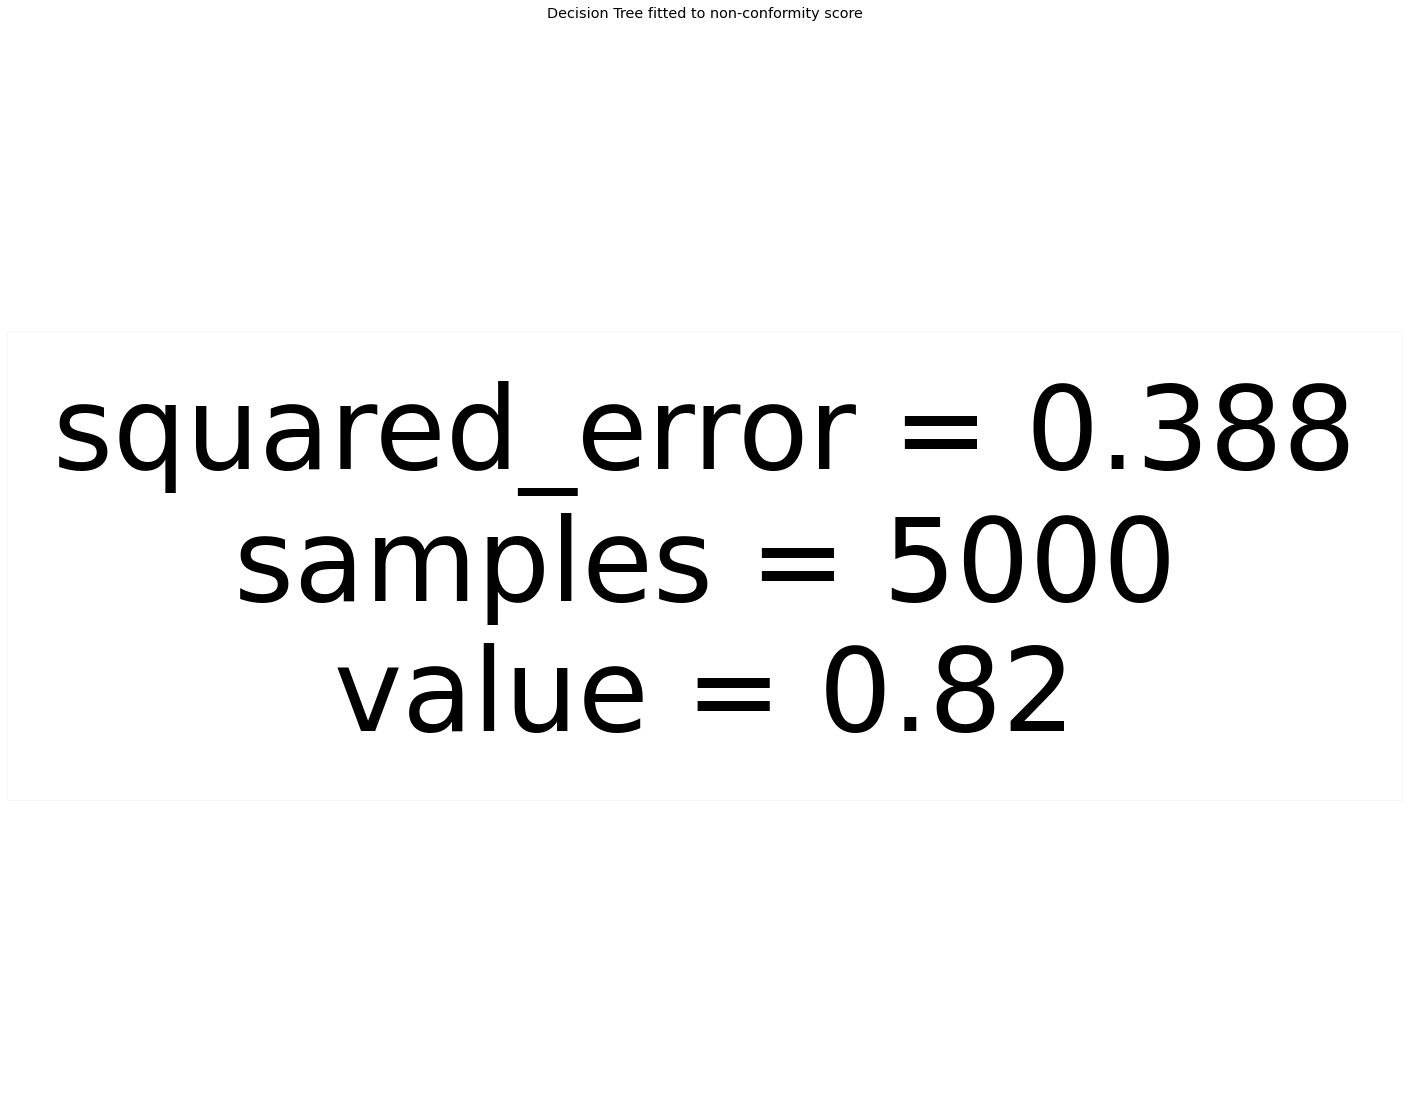

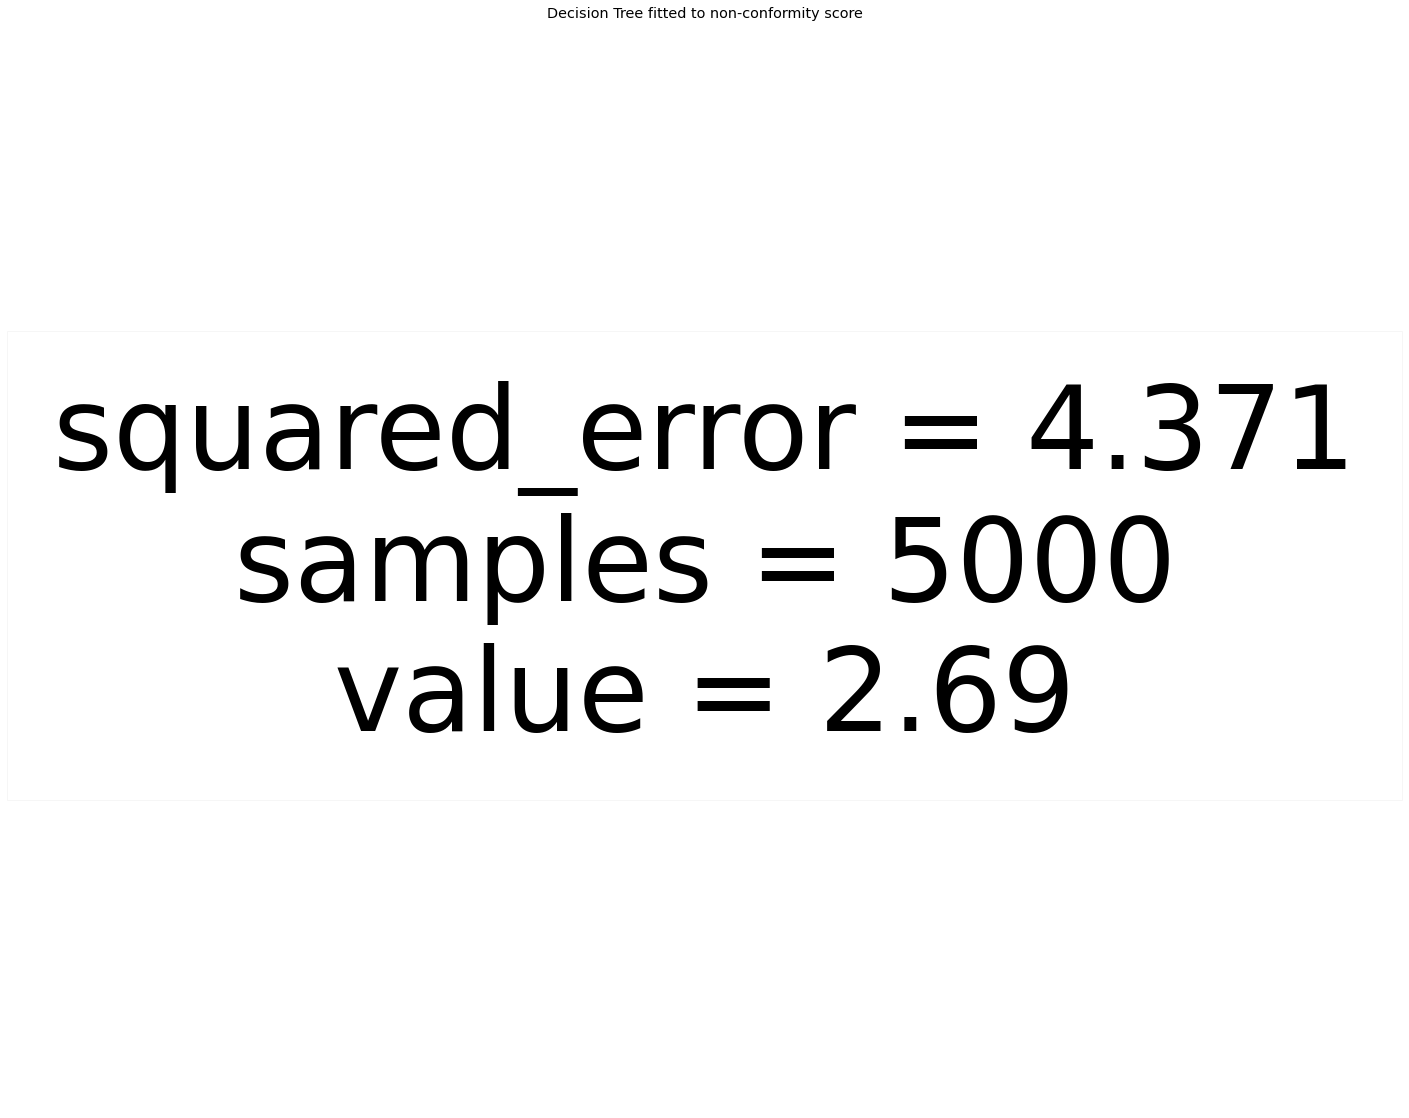

In [83]:
# homoscedastic data
homoc_metrics = testing_metrics_sim(random_seed = 950, random_state = 650, n_estimators = 300, valid_test_size=0.5, nbins = 30, noise = False, 
                    split_calib = True, valid_split = False, valid_prune = True, valid_min_sample = 150, min_samples_leaf = 100)

In [84]:
homoc_metrics

,Methods,valid pred set,smis,max pred set,Average marginal coverage,Average interval length,Average interval length given coverage,Average distance,Median distance,Max distance
0,LOCART,0.04280,-4.145858,0.155556,0.9092,3.369629,3.369629,0.010838,0.009,0.121
1,Weighted LOCART,0.04592,-4.211794,0.127586,0.9052,3.399524,3.414962,0.031353,0.026,0.176
2,Regresion split,0.04528,-4.146682,0.152747,0.9100,3.378272,3.378272,0.010964,0.009,0.121
3,Weighted regression split,0.04864,-4.217240,0.138095,0.9096,3.447493,3.461806,0.030937,0.027,0.169
4,Mondrian regression split,0.04900,-4.175534,0.123529,0.9000,3.347433,3.356299,0.025124,0.021,0.178


Fitting locart to toy example:
Time Elapsed to fit Locart:  70.484215259552
Computing metrics
Time Elapsed to compute metrics for Locart:  2.3457400798797607
Fitting weighted locart to toy example:
Time Elapsed to fit Locart:  168.41634249687195
Computing metrics
Time Elapsed to compute metrics for Locart:  3.9943454265594482
Fitting regression split
Time Elapsed to fit regression split:  69.82865810394287
Computing metrics
Time Elapsed to compute statistics for regression split:  2.327998161315918
Fitting weighted regression split
Time Elapsed to fit weighted regression split:  169.19070291519165
Computing metrics
Time Elapsed to compute statistics for weighted regression split:  169.19070291519165
Fitting mondrian regression split
Time Elapsed to fit mondrian regression split:  70.57598924636841
Computing metrics
Cutoff points of wlocart: [5.46482839]
Cutoff point of wicp: 5.518541829685063


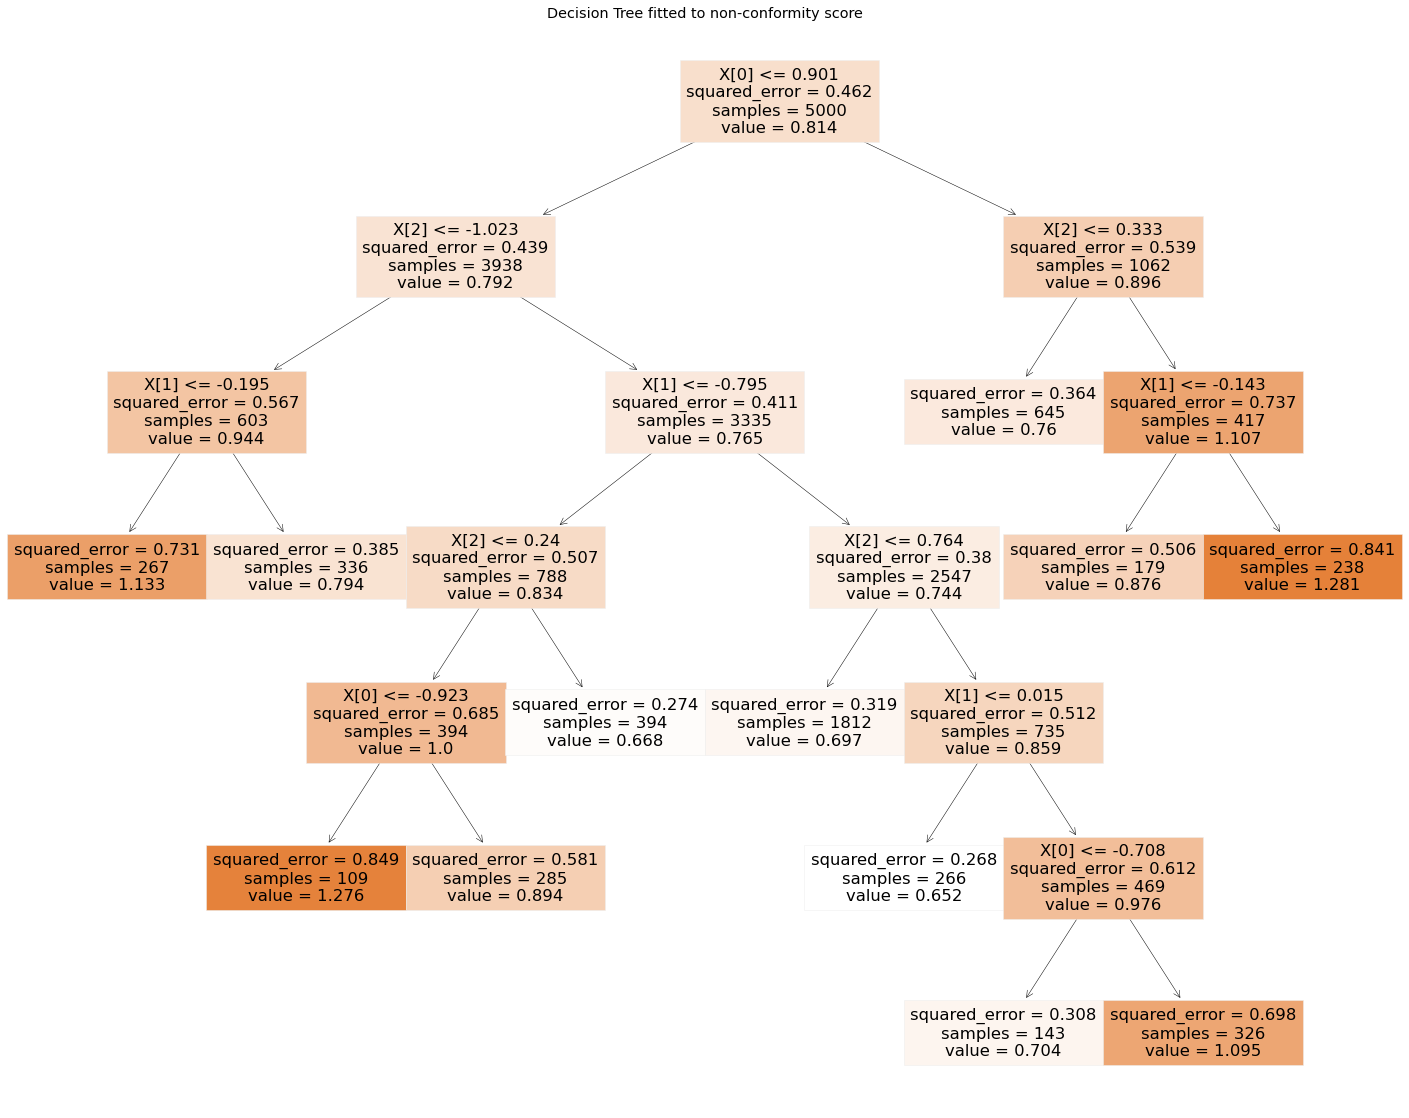

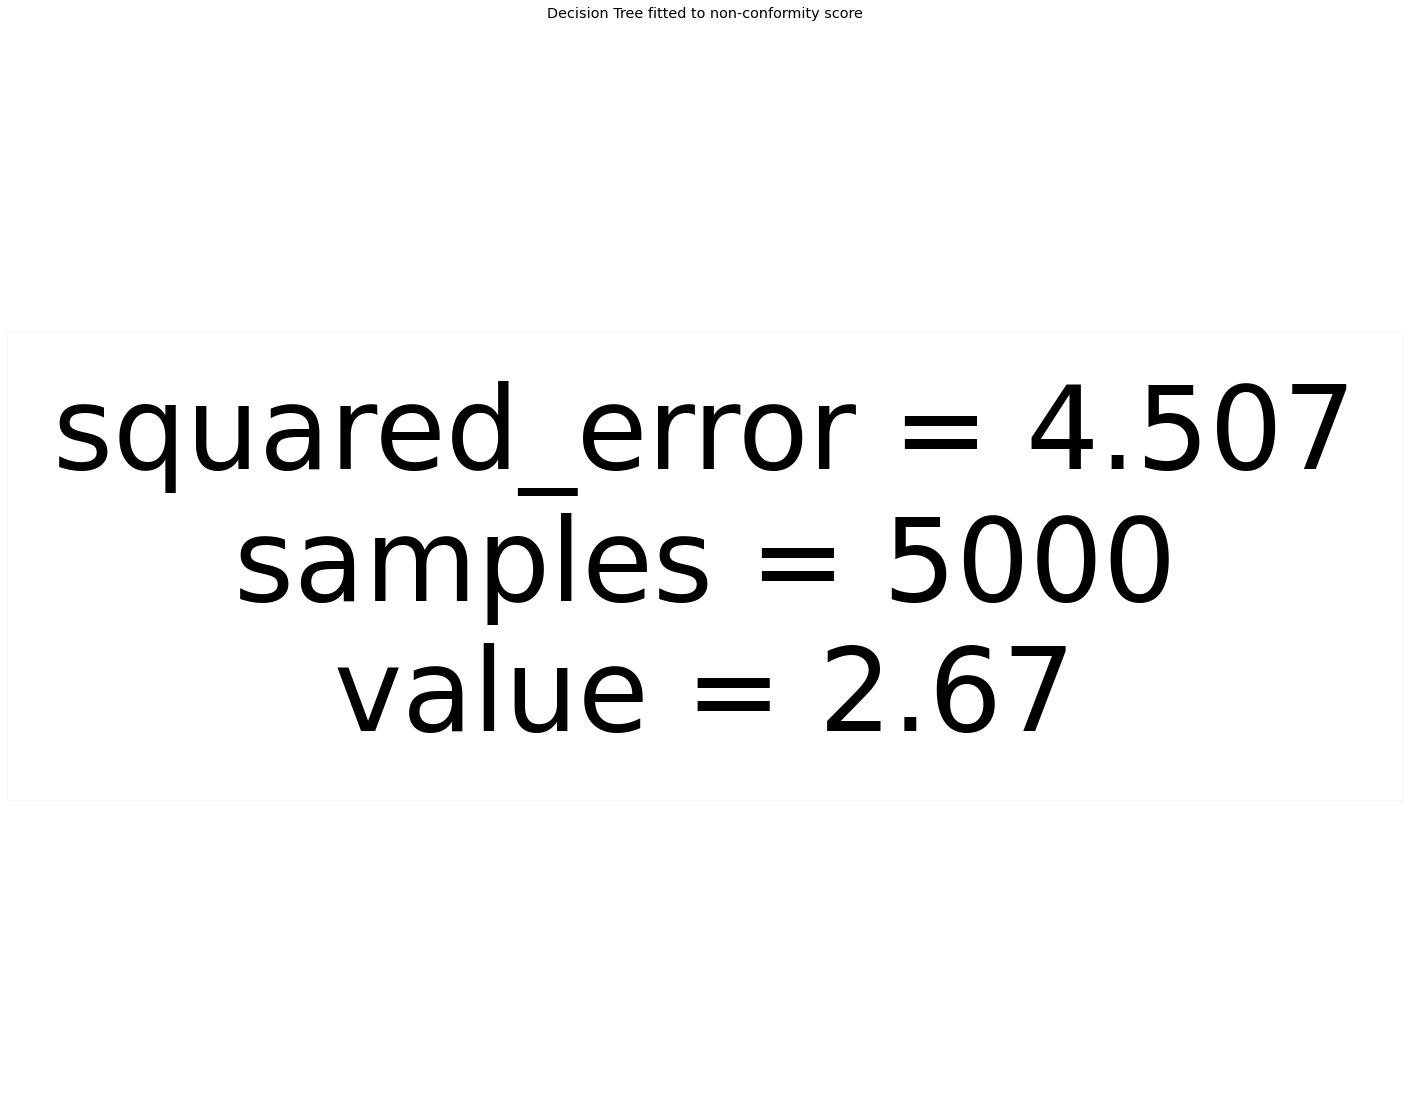

In [85]:
# heteroscedastic data
heteroc_metrics = testing_metrics_sim(kind = "heteroscedastic", hetero_value = 0.25, random_seed = 950, random_state = 650, n_estimators = 300,
                                    valid_test_size=0.5, nbins = 30, noise = False, split_calib = True, valid_split = False, valid_prune = True, 
                                    valid_min_sample = 150, min_samples_leaf = 100)

In [86]:
heteroc_metrics

,Methods,valid pred set,smis,max pred set,Average marginal coverage,Average interval length,Average interval length given coverage,Average distance,Median distance,Max distance
0,LOCART,0.06000,-4.408283,0.144898,0.8966,3.385746,3.389356,0.059622,0.055,0.296
1,Weighted LOCART,0.04852,-4.324031,0.097917,0.9012,3.387413,3.394133,0.048061,0.042,0.232
2,Regresion split,0.06228,-4.527795,0.180000,0.8980,3.437851,3.437851,0.068651,0.066,0.287
3,Weighted regression split,0.05280,-4.325558,0.131638,0.9044,3.420708,3.426795,0.047386,0.042,0.226
4,Mondrian regression split,0.05024,-4.285873,0.089873,0.8980,3.311155,3.319848,0.045624,0.039,0.315


Fitting locart to toy example:
Time Elapsed to fit Locart:  84.09059691429138
Computing metrics
Time Elapsed to compute metrics for Locart:  2.474236488342285
Fitting weighted locart to toy example:
Time Elapsed to fit Locart:  215.25436806678772
Computing metrics
Time Elapsed to compute metrics for Locart:  4.228595733642578
Fitting regression split
Time Elapsed to fit regression split:  84.75295424461365
Computing metrics
Time Elapsed to compute statistics for regression split:  2.623897075653076
Fitting weighted regression split
Time Elapsed to fit weighted regression split:  220.00144386291504
Computing metrics
Time Elapsed to compute statistics for weighted regression split:  220.00144386291504
Fitting mondrian regression split
Time Elapsed to fit mondrian regression split:  85.09171319007874
Computing metrics
Cutoff points of wlocart: [4.79625564]
Cutoff point of wicp: 4.680656453864487


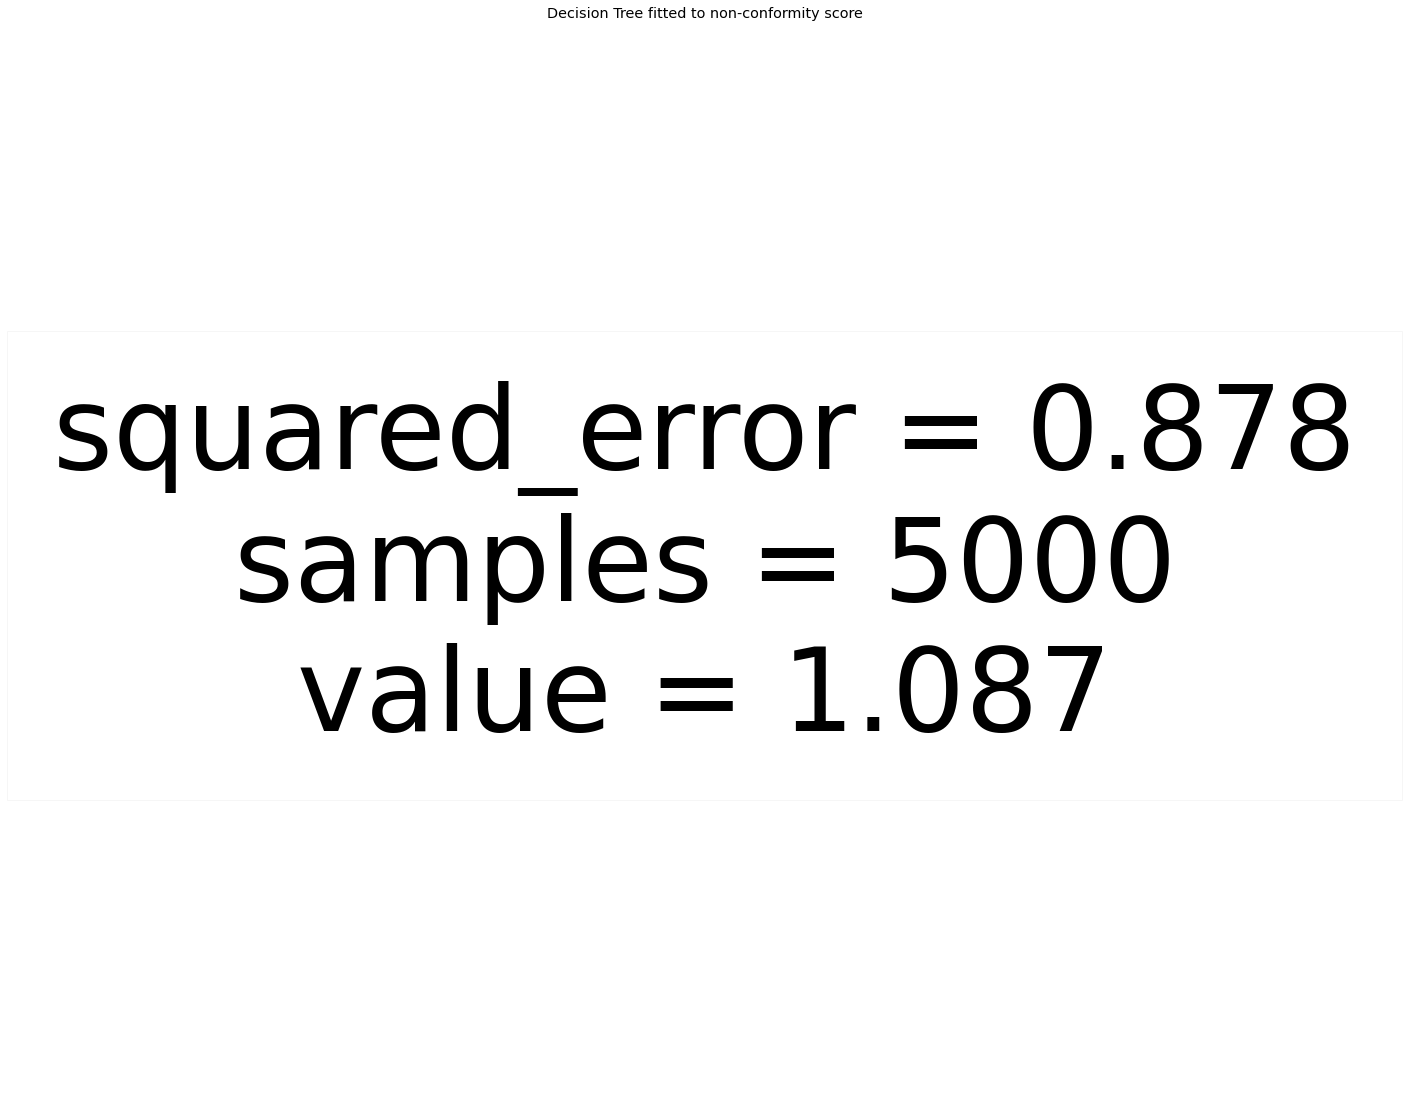

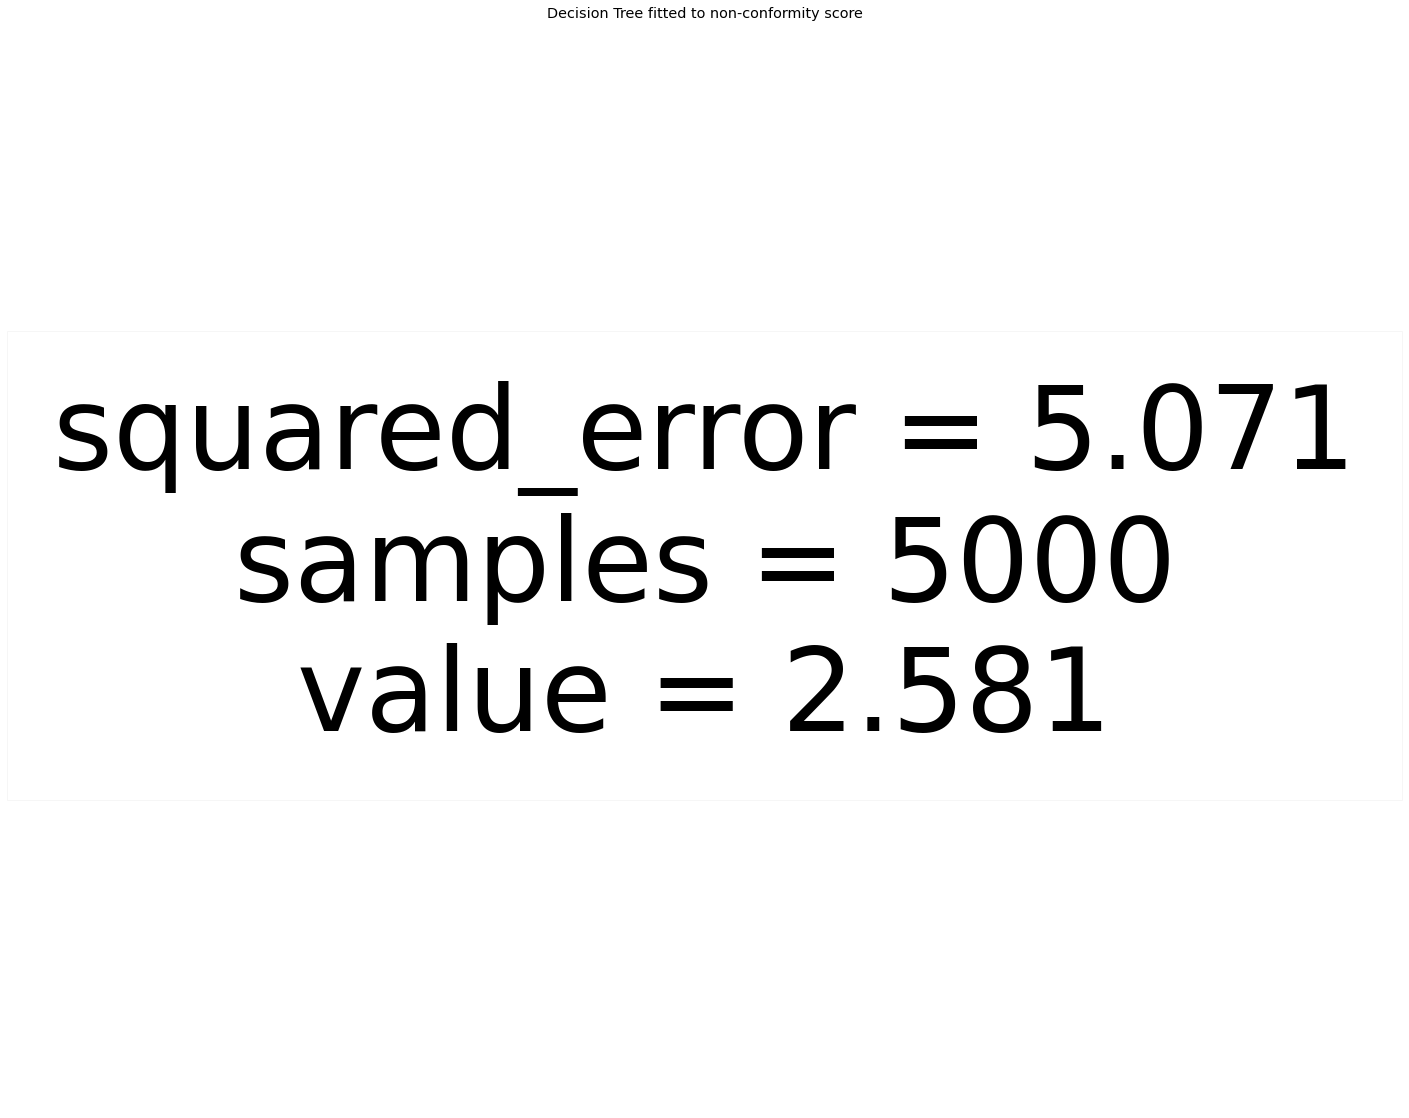

In [87]:
asym_metrics = testing_metrics_sim(kind = "asymmetric", random_seed = 950, random_state = 650, n_estimators = 300, asym_value = 0.6, valid_test_size=0.5, nbins = 30, noise = False, 
                    split_calib = True, valid_split = False, valid_prune = True, valid_min_sample = 150, min_samples_leaf = 100)

In [88]:
asym_metrics

,Methods,valid pred set,smis,max pred set,Average marginal coverage,Average interval length,Average interval length given coverage,Average distance,Median distance,Max distance
0,LOCART,0.04988,-6.653820,0.172727,0.9010,4.237457,4.237457,0.049550,0.039,0.634
1,Weighted LOCART,0.04900,-6.520597,0.095730,0.9052,4.135325,4.152109,0.039426,0.034,0.357
2,Regresion split,0.05336,-6.654092,0.133333,0.8982,4.165467,4.165467,0.050594,0.039,0.639
3,Weighted regression split,0.05120,-6.514218,0.124066,0.8994,4.035656,4.052168,0.040983,0.034,0.369
4,Mondrian regression split,0.04696,-6.558965,0.133333,0.9022,4.094706,4.100876,0.043140,0.036,0.481


Fitting locart to toy example:
Time Elapsed to fit Locart:  86.79588603973389
Computing metrics
Time Elapsed to compute metrics for Locart:  2.38360857963562
Fitting weighted locart to toy example:
Time Elapsed to fit Locart:  191.74372172355652
Computing metrics
Time Elapsed to compute metrics for Locart:  3.9858250617980957
Fitting regression split
Time Elapsed to fit regression split:  86.74610686302185
Computing metrics
Time Elapsed to compute statistics for regression split:  2.4953114986419678
Fitting weighted regression split
Time Elapsed to fit weighted regression split:  191.97755646705627
Computing metrics
Time Elapsed to compute statistics for weighted regression split:  191.97755646705627
Fitting mondrian regression split
Time Elapsed to fit mondrian regression split:  87.1288492679596
Computing metrics
Cutoff points of wlocart: [4.80728208]
Cutoff point of wicp: 4.931562931103116


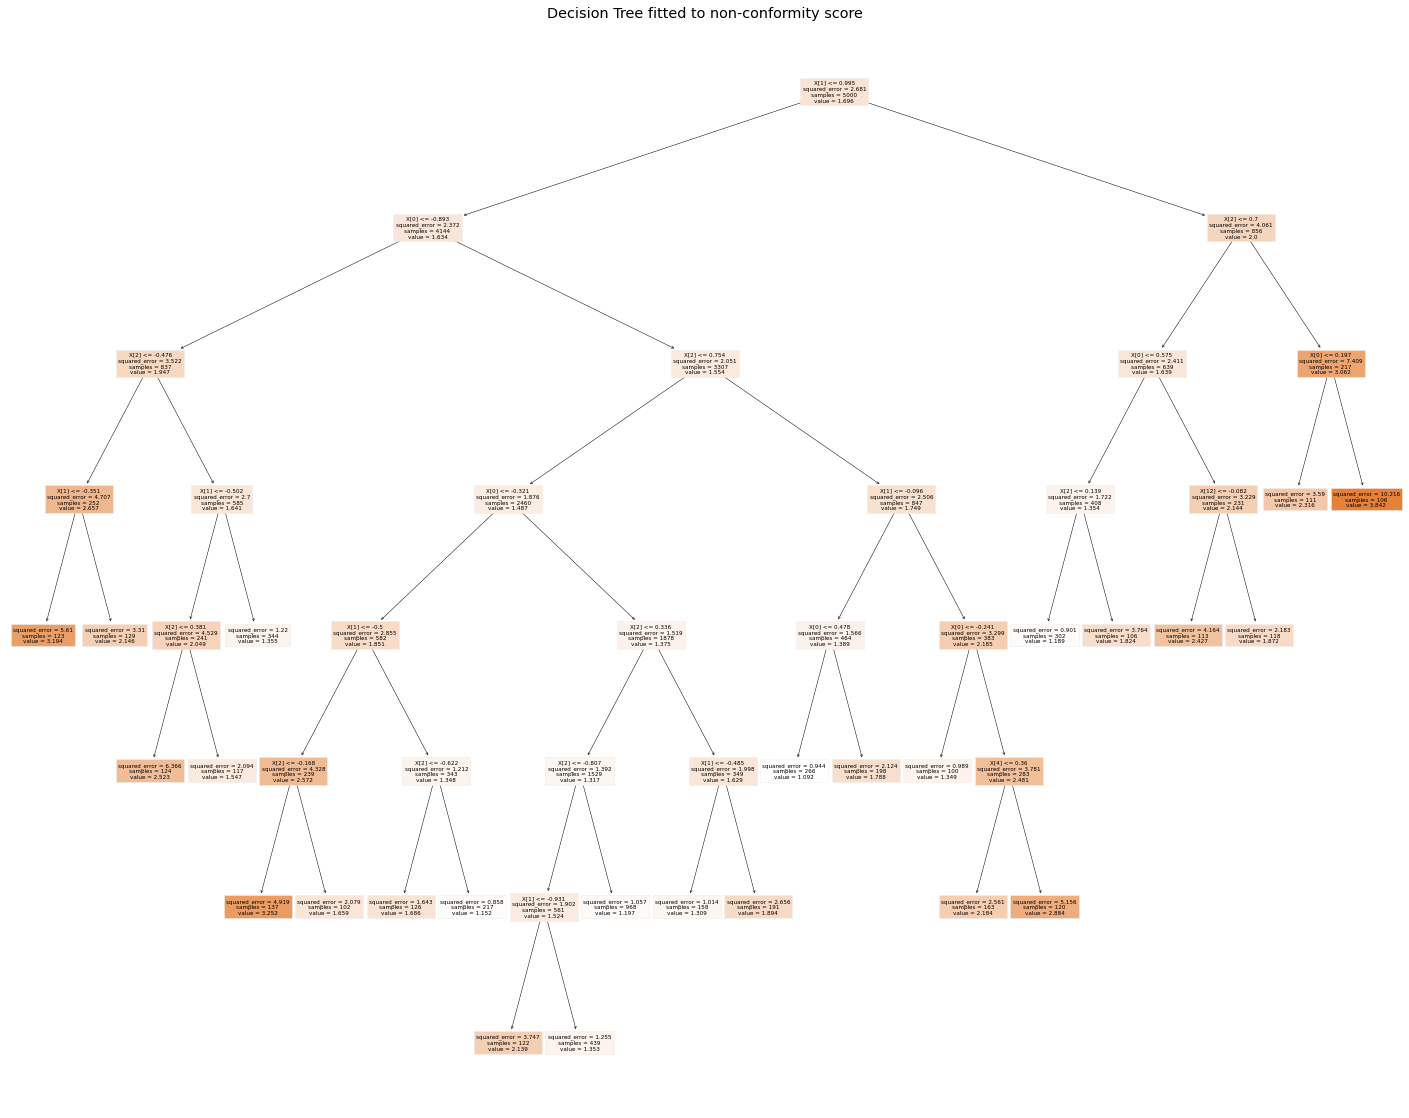

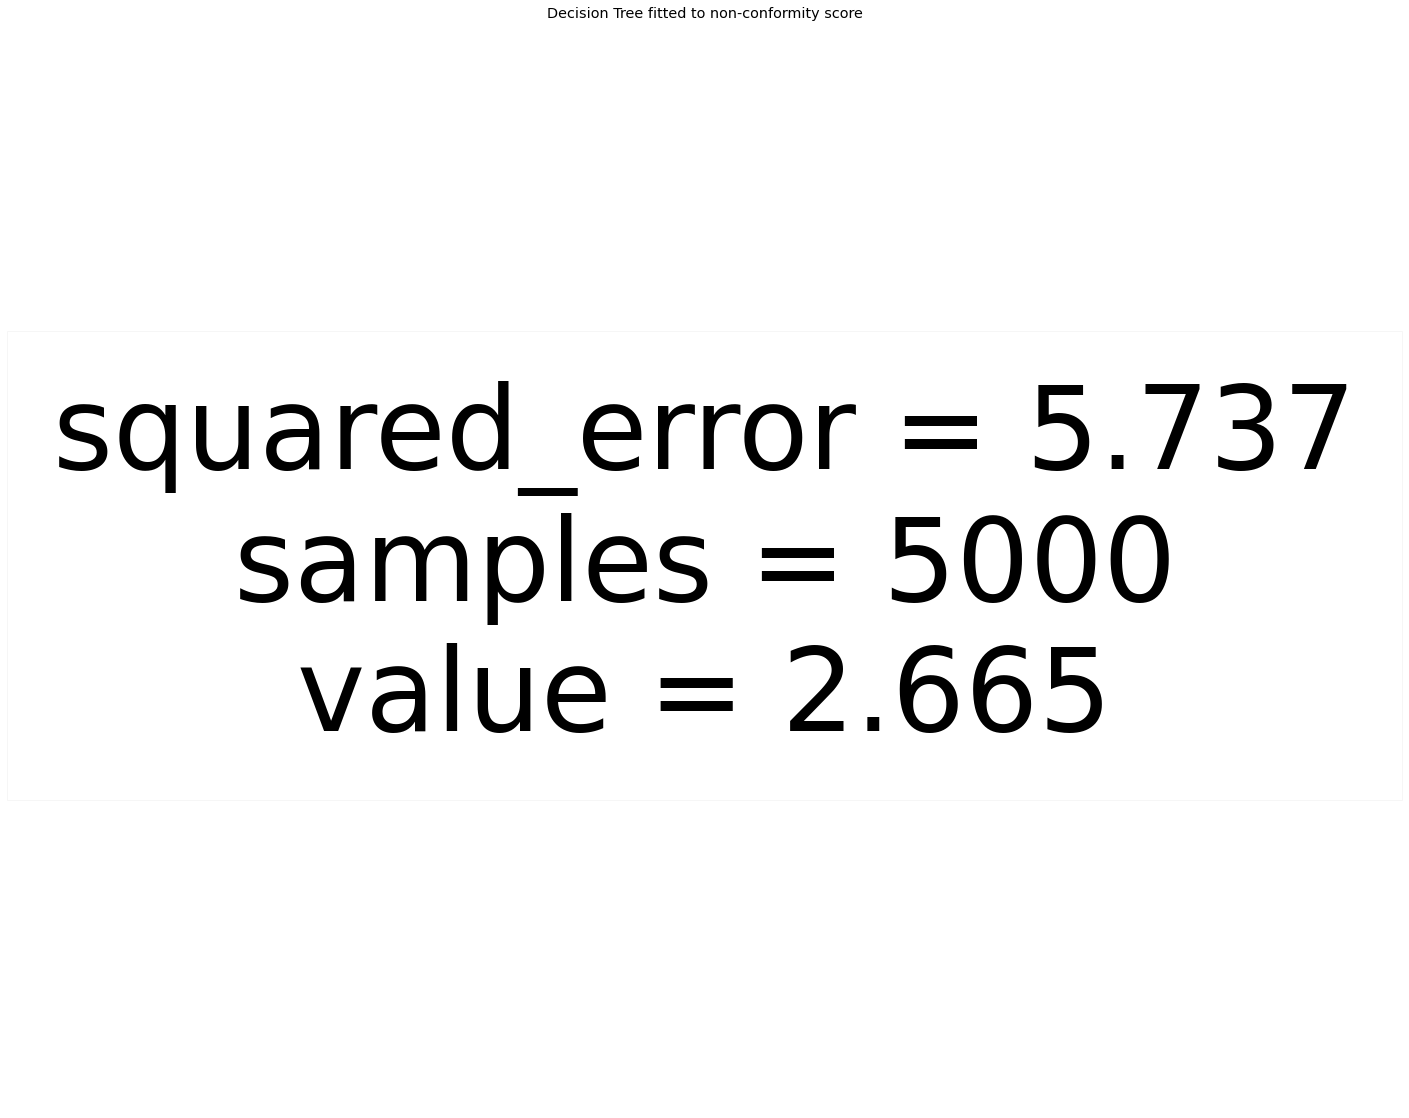

In [89]:
asym_metrics_v2 = testing_metrics_sim(kind = "asymmetric", random_seed = 950, random_state = 650, n_estimators = 300, asym_value = 1.5, valid_test_size=0.5, nbins = 30, noise = False, 
                    split_calib = True, valid_split = False, valid_prune = True, valid_min_sample = 150, min_samples_leaf = 100)

In [90]:
asym_metrics_v2

,Methods,valid pred set,smis,max pred set,Average marginal coverage,Average interval length,Average interval length given coverage,Average distance,Median distance,Max distance
0,LOCART,0.04568,-9.770496,0.109150,0.8936,6.408551,6.435119,0.061143,0.049,0.633
1,Weighted LOCART,0.05100,-9.587440,0.182895,0.9026,6.244226,6.262532,0.052289,0.045,0.385
2,Regresion split,0.07196,-10.619125,0.316185,0.9032,6.999030,6.999030,0.080579,0.068,0.640
3,Weighted regression split,0.04684,-9.601337,0.120884,0.9090,6.405655,6.429259,0.050196,0.045,0.363
4,Mondrian regression split,0.05188,-9.629392,0.140642,0.8970,6.037872,6.067506,0.055598,0.047,0.346


Fitting locart to toy example:
Time Elapsed to fit Locart:  128.0200731754303
Computing metrics
Time Elapsed to compute metrics for Locart:  2.477123975753784
Fitting weighted locart to toy example:
Time Elapsed to fit Locart:  225.47808122634888
Computing metrics
Time Elapsed to compute metrics for Locart:  4.245304584503174
Fitting regression split
Time Elapsed to fit regression split:  126.36950039863586
Computing metrics
Time Elapsed to compute statistics for regression split:  2.427922010421753
Fitting weighted regression split
Time Elapsed to fit weighted regression split:  227.36862921714783
Computing metrics
Time Elapsed to compute statistics for weighted regression split:  227.36862921714783
Fitting mondrian regression split
Time Elapsed to fit mondrian regression split:  127.64970970153809
Computing metrics
Cutoff points of wlocart: [5.51492405]
Cutoff point of wicp: 5.54552673426254


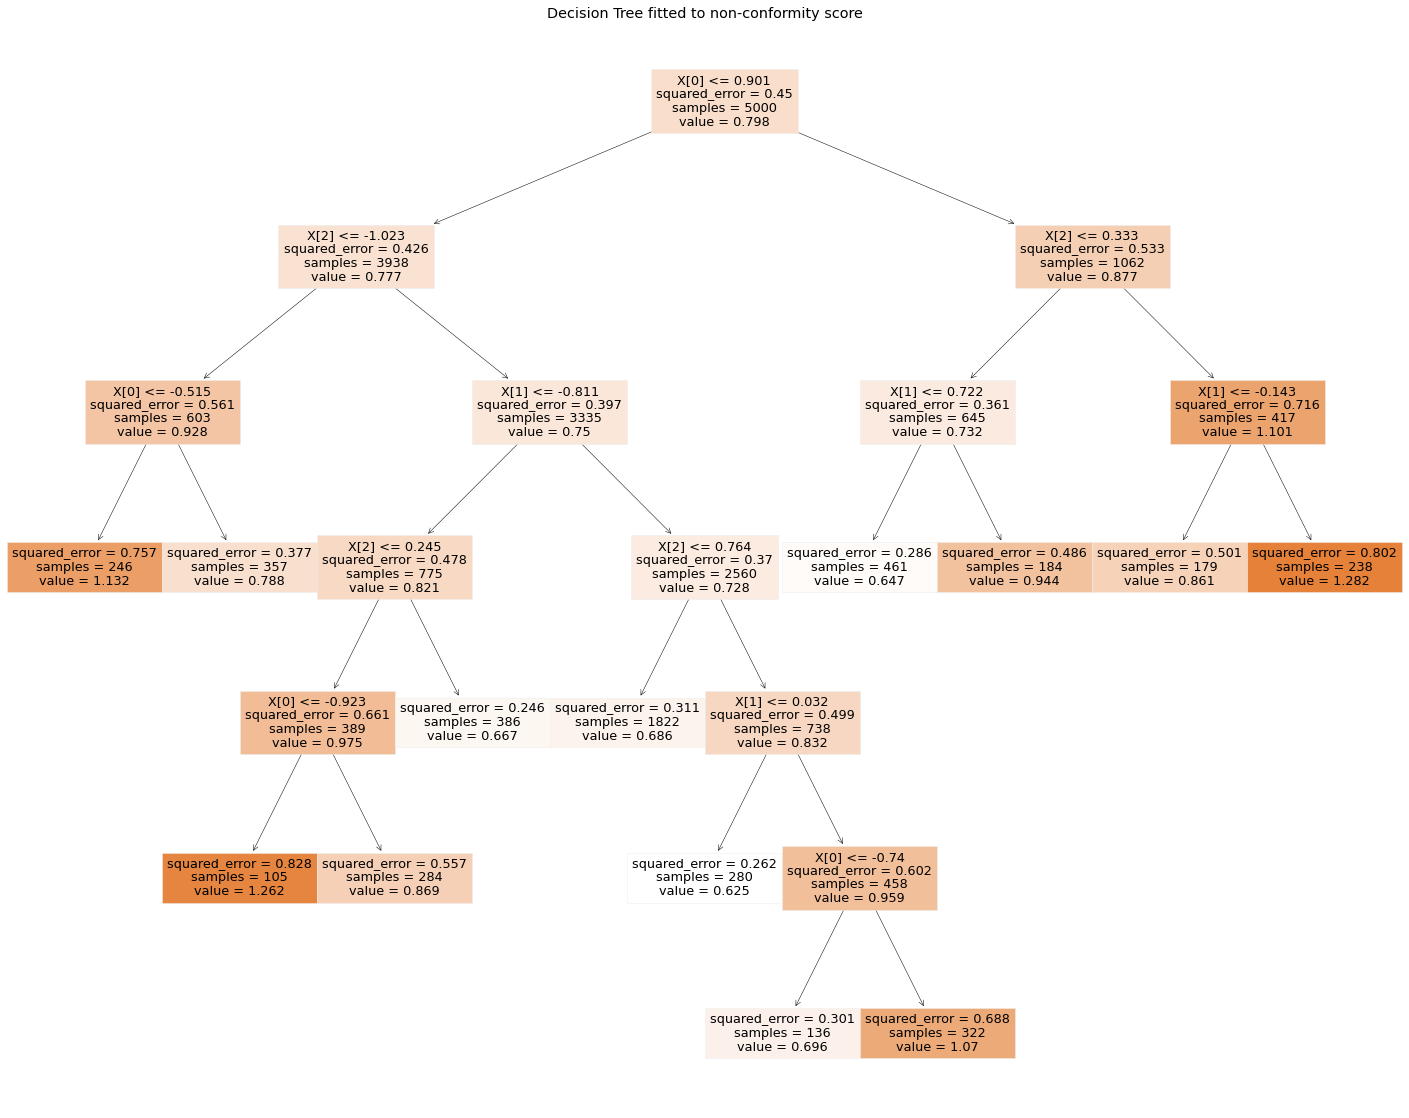

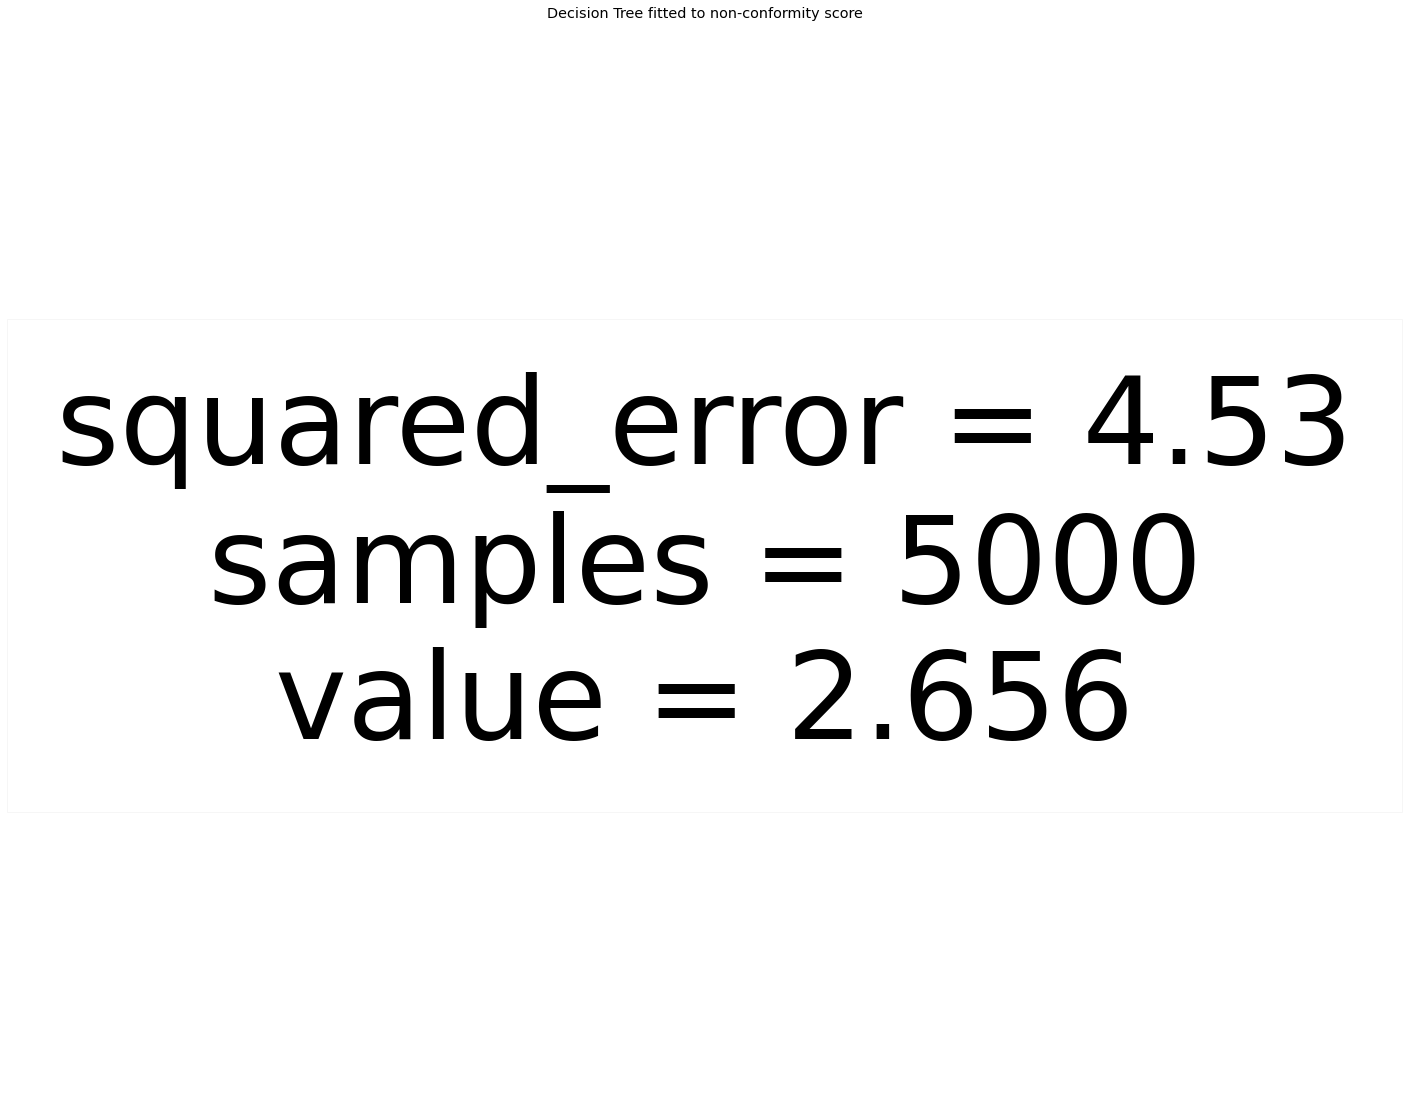

In [91]:
non_cor_heteroc = testing_metrics_sim( kind = "non_cor_heteroscedastic", hetero_value = 0.25, random_seed = 950, random_state = 650, n_estimators = 300,
                                      noise = False, valid_test_size = 0.5, nbins = 30, split_calib = True, valid_split = False, valid_prune = True, 
                                      valid_min_sample = 150, min_samples_leaf = 100)

In [92]:
non_cor_heteroc

,Methods,valid pred set,smis,max pred set,Average marginal coverage,Average interval length,Average interval length given coverage,Average distance,Median distance,Max distance
0,LOCART,0.05420,-4.356969,0.154237,0.9022,3.349276,3.352431,0.059109,0.055,0.233
1,Weighted LOCART,0.05088,-4.265270,0.115859,0.9040,3.362646,3.369571,0.047776,0.042,0.225
2,Regresion split,0.05884,-4.479672,0.158929,0.8972,3.380902,3.380902,0.068900,0.067,0.277
3,Weighted regression split,0.05160,-4.266411,0.115859,0.9046,3.381306,3.388396,0.047404,0.042,0.224
4,Mondrian regression split,0.05680,-4.459146,0.152525,0.8980,3.377032,3.387917,0.063630,0.061,0.339


## Changing model to KNN and maintaining number of variables $p$:

Fitting locart to toy example:
Time Elapsed to fit Locart:  21.562671899795532
Computing metrics
Time Elapsed to compute metrics for Locart:  7.268968820571899
Fitting weighted locart to toy example:
Time Elapsed to fit Locart:  23.85697865486145
Computing metrics
Time Elapsed to compute metrics for Locart:  8.578836441040039
Fitting regression split
Time Elapsed to fit regression split:  3.3144986629486084
Computing metrics
Time Elapsed to compute statistics for regression split:  4.5433173179626465
Fitting weighted regression split
Time Elapsed to fit weighted regression split:  10.723764181137085
Computing metrics
Time Elapsed to compute statistics for weighted regression split:  10.723764181137085
Fitting mondrian regression split
Time Elapsed to fit mondrian regression split:  25.167250871658325
Computing metrics
Cutoff points of wlocart: [2.19157276]
Cutoff point of wicp: 2.233610084971219


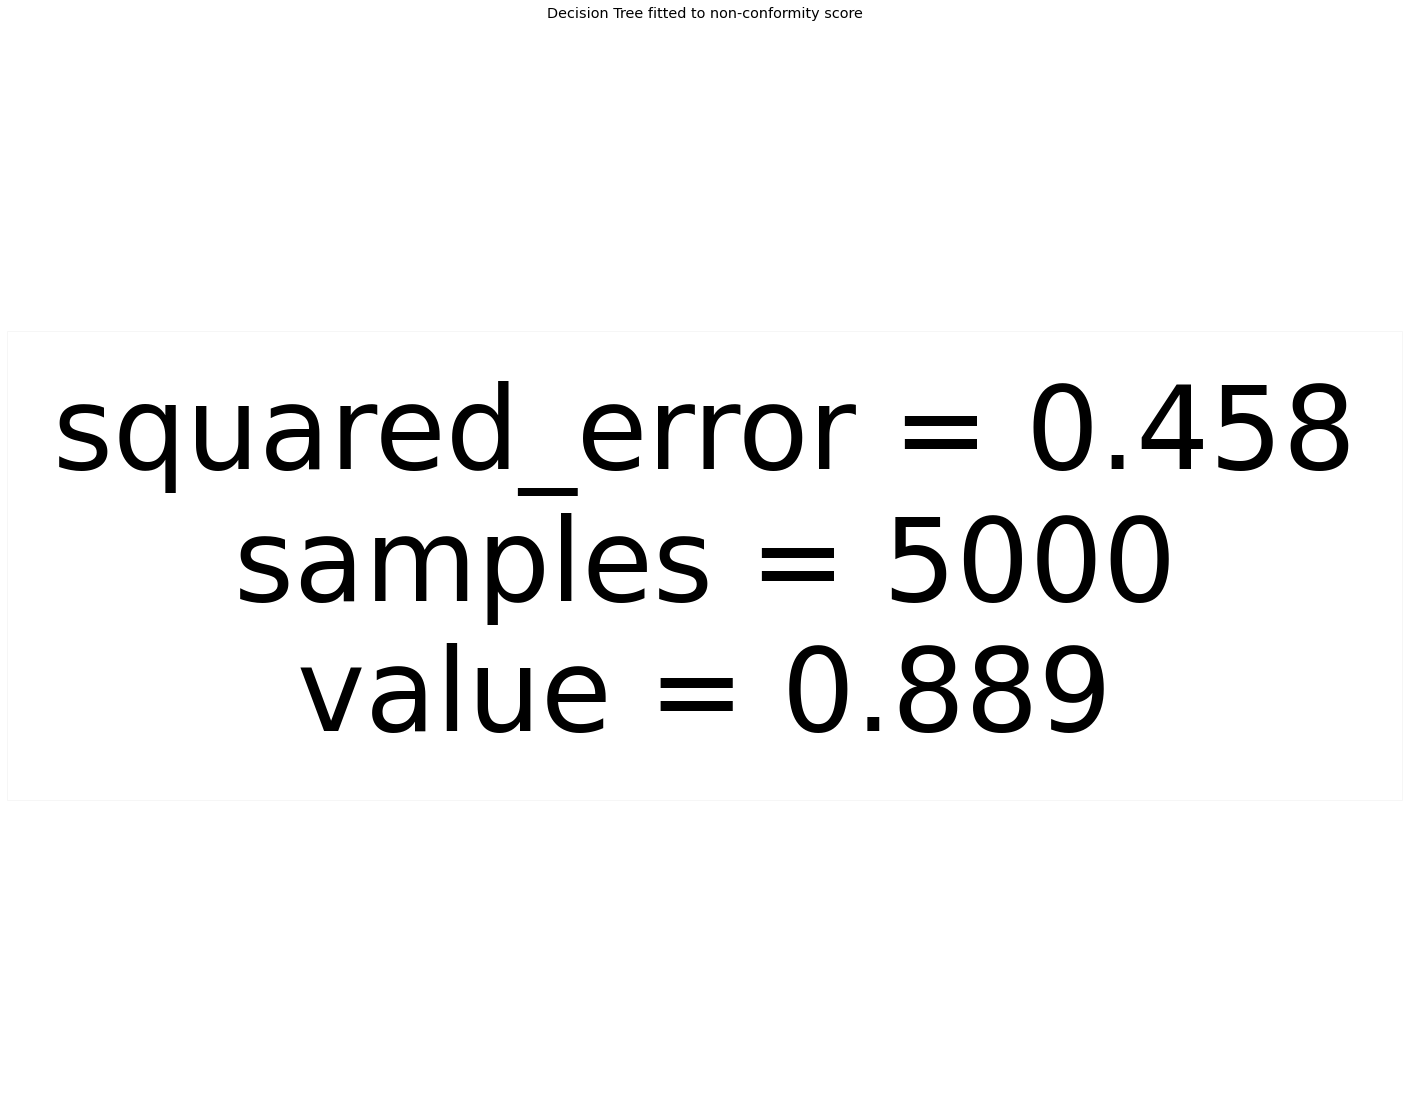

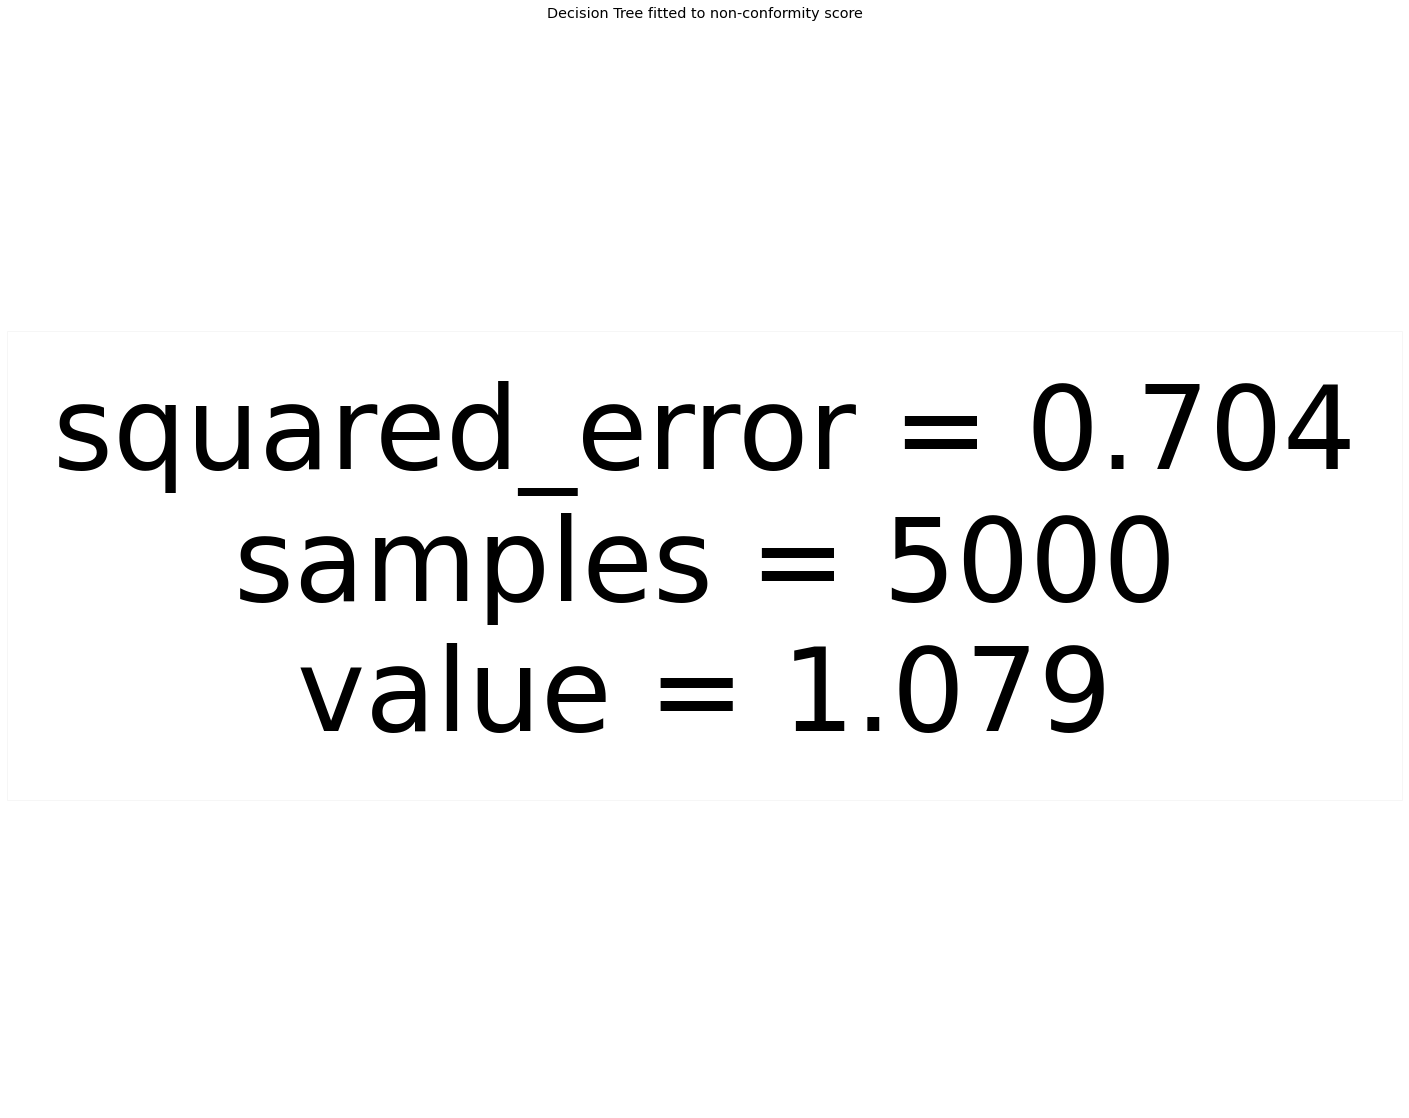

In [93]:
homoc_metrics = testing_metrics_sim(base_model = KNeighborsRegressor, n_neighbors = 30, random_seed = 950, valid_test_size=0.5, nbins = 30, noise = False, 
                    split_calib = True, valid_split = False, valid_prune = True, valid_min_sample = 150, min_samples_leaf = 150)

In [94]:
homoc_metrics

,Methods,valid pred set,smis,max pred set,Average marginal coverage,Average interval length,Average interval length given coverage,Average distance,Median distance,Max distance
0,LOCART,0.05192,-4.522250,0.138739,0.9038,3.685293,3.685293,0.032953,0.027,0.335
1,Weighted LOCART,0.05100,-4.649125,0.117557,0.8962,3.685550,3.713165,0.048938,0.039,0.468
2,Regresion split,0.05192,-4.522481,0.138739,0.9038,3.691359,3.691359,0.033072,0.028,0.333
3,Weighted regression split,0.04928,-4.653176,0.148731,0.9018,3.756244,3.783794,0.048390,0.040,0.453
4,Mondrian regression split,0.05104,-4.540951,0.120000,0.8998,3.636644,3.641440,0.036561,0.028,0.341


Fitting locart to toy example:
Time Elapsed to fit Locart:  4.5515313148498535
Computing metrics
Time Elapsed to compute metrics for Locart:  4.393813610076904
Fitting weighted locart to toy example:
Time Elapsed to fit Locart:  11.228533506393433
Computing metrics
Time Elapsed to compute metrics for Locart:  8.457885026931763
Fitting regression split
Time Elapsed to fit regression split:  3.537193775177002
Computing metrics
Time Elapsed to compute statistics for regression split:  4.413337707519531
Fitting weighted regression split
Time Elapsed to fit weighted regression split:  10.59660792350769
Computing metrics
Time Elapsed to compute statistics for weighted regression split:  10.59660792350769
Fitting mondrian regression split
Time Elapsed to fit mondrian regression split:  24.2407443523407
Computing metrics
Cutoff points of wlocart: [2.31011155]
Cutoff point of wicp: 2.3187401422254146


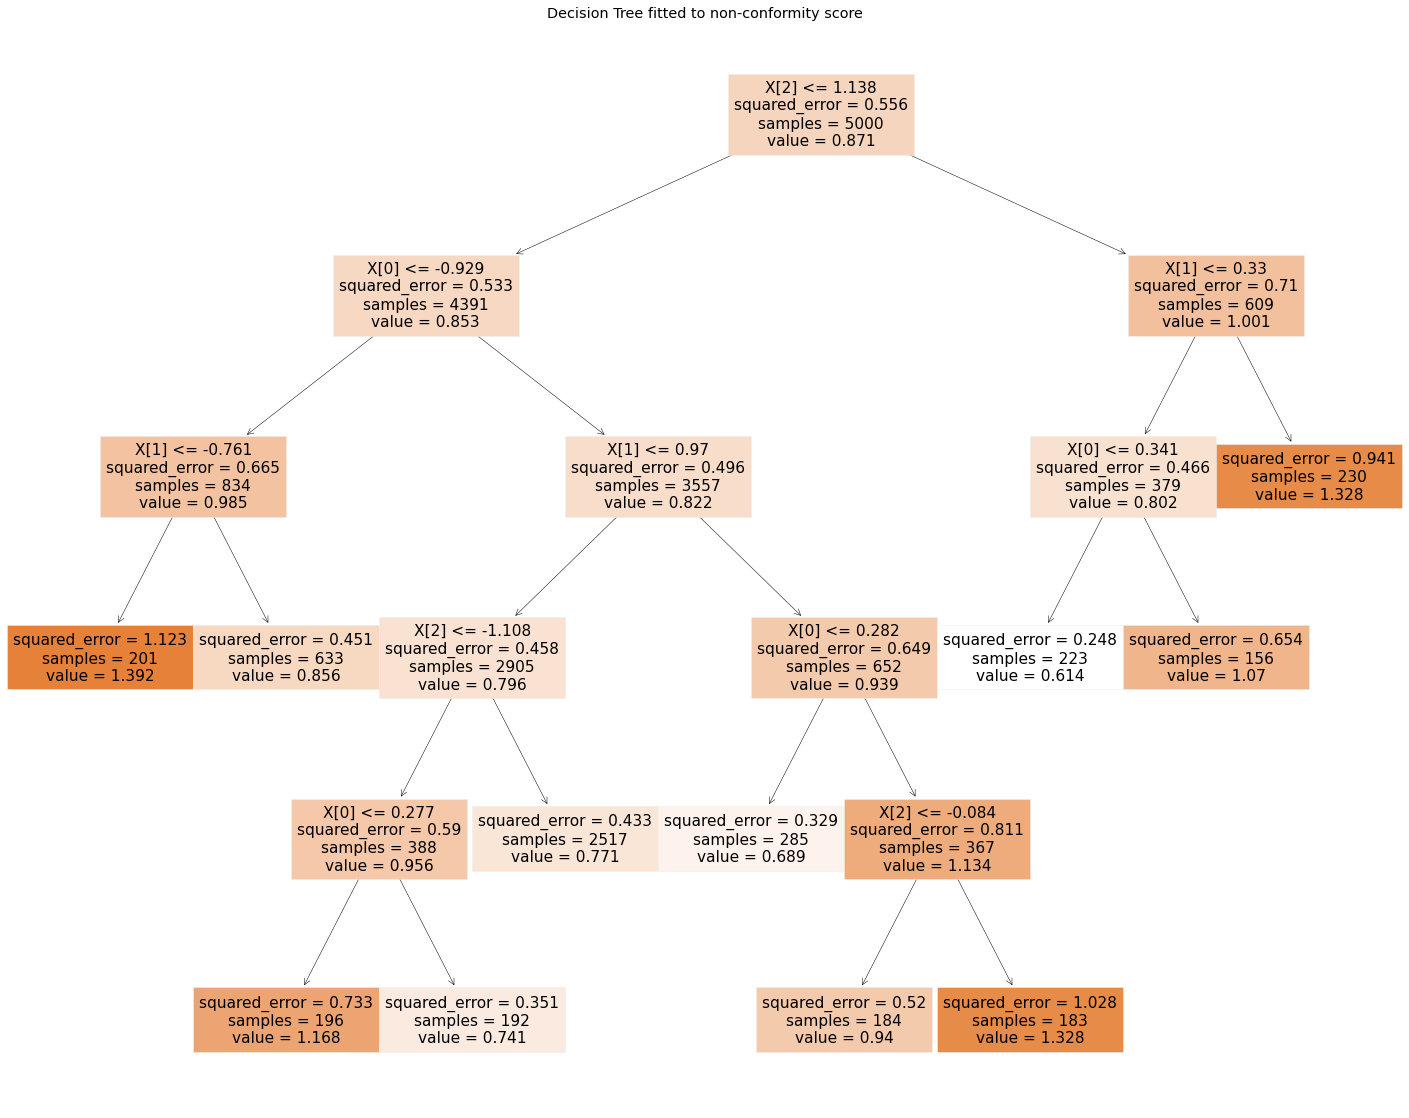

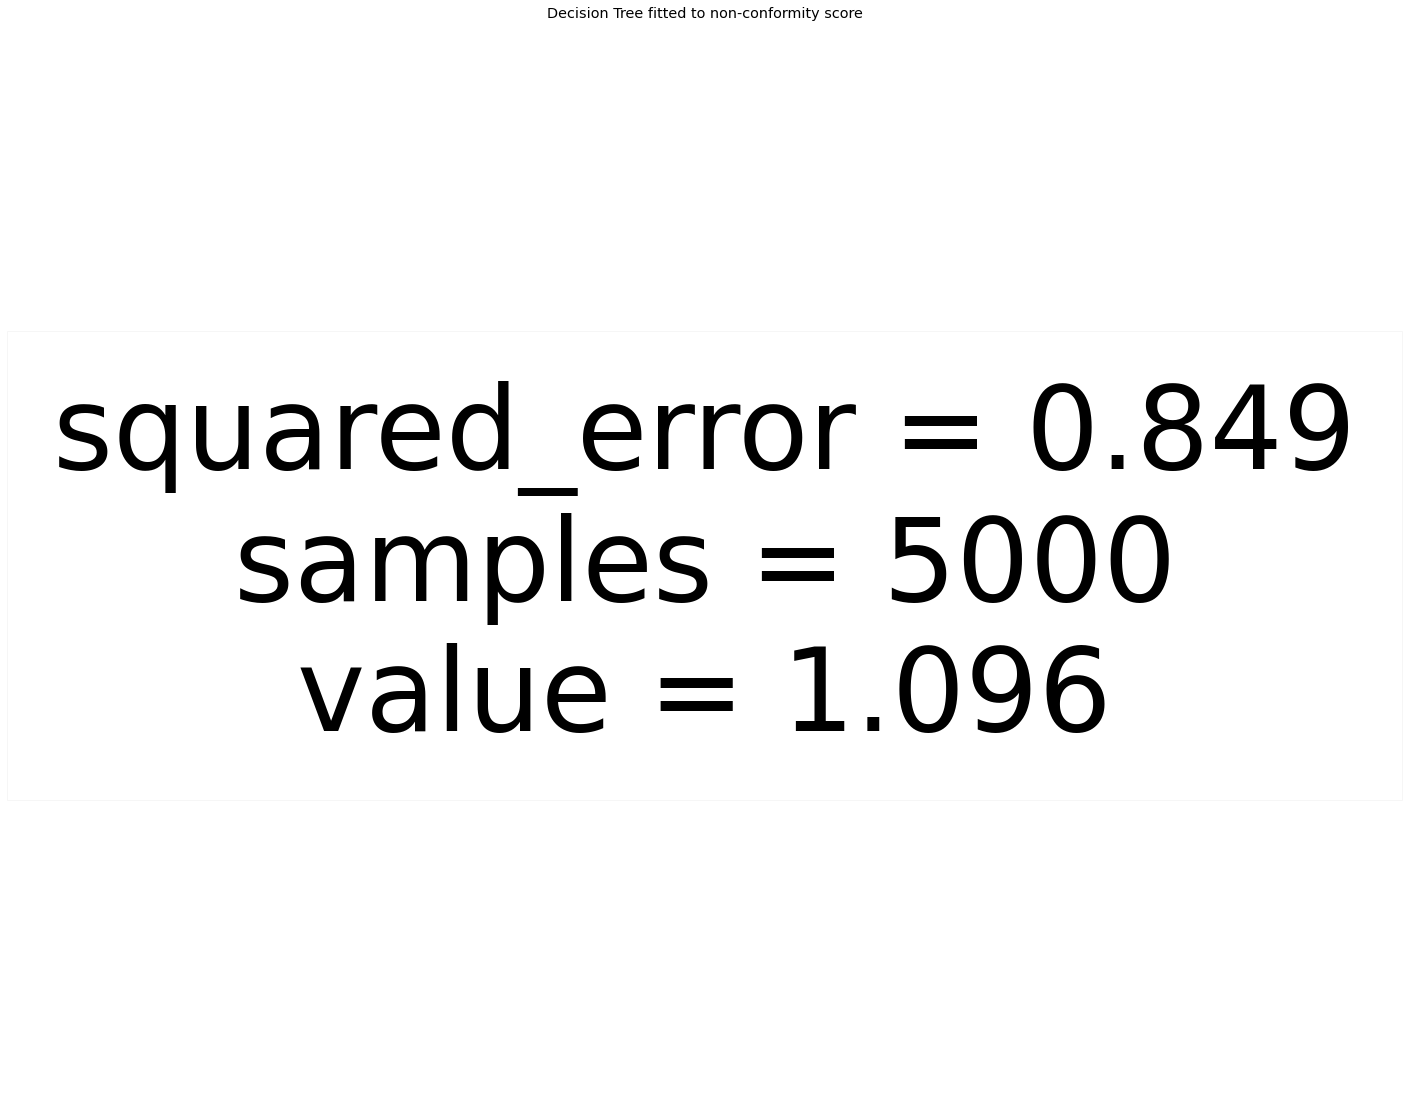

In [95]:
heteroc_metrics = testing_metrics_sim(base_model = KNeighborsRegressor, kind = "heteroscedastic", n_neighbors = 30, hetero_value = 0.25, random_seed = 950,
                                      valid_test_size=0.5, nbins = 30, noise = False,  split_calib = True, valid_split = False, valid_prune = True, 
                                      valid_min_sample = 150, min_samples_leaf = 150)

In [96]:
heteroc_metrics

,Methods,valid pred set,smis,max pred set,Average marginal coverage,Average interval length,Average interval length given coverage,Average distance,Median distance,Max distance
0,LOCART,0.06820,-4.859357,0.265591,0.8870,3.596813,3.597350,0.071681,0.067,0.365
1,Weighted LOCART,0.05392,-4.903478,0.181437,0.8964,3.719327,3.730428,0.072467,0.067,0.403
2,Regresion split,0.07312,-4.966281,0.281910,0.9000,3.730715,3.730715,0.077942,0.075,0.393
3,Weighted regression split,0.05536,-4.903441,0.181437,0.8974,3.733219,3.744298,0.072194,0.067,0.399
4,Mondrian regression split,0.05396,-4.656295,0.140000,0.8886,3.522612,3.531040,0.055230,0.046,0.335


Fitting locart to toy example:
Time Elapsed to fit Locart:  3.831451177597046
Computing metrics
Time Elapsed to compute metrics for Locart:  4.4267168045043945
Fitting weighted locart to toy example:
Time Elapsed to fit Locart:  11.036625146865845
Computing metrics
Time Elapsed to compute metrics for Locart:  8.407546758651733
Fitting regression split
Time Elapsed to fit regression split:  3.632622241973877
Computing metrics
Time Elapsed to compute statistics for regression split:  4.491111993789673
Fitting weighted regression split
Time Elapsed to fit weighted regression split:  10.608768939971924
Computing metrics
Time Elapsed to compute statistics for weighted regression split:  10.608768939971924
Fitting mondrian regression split
Time Elapsed to fit mondrian regression split:  29.22471523284912
Computing metrics
Cutoff points of wlocart: [1.99329537 2.91550947]
Cutoff point of wicp: 2.0299569477458355


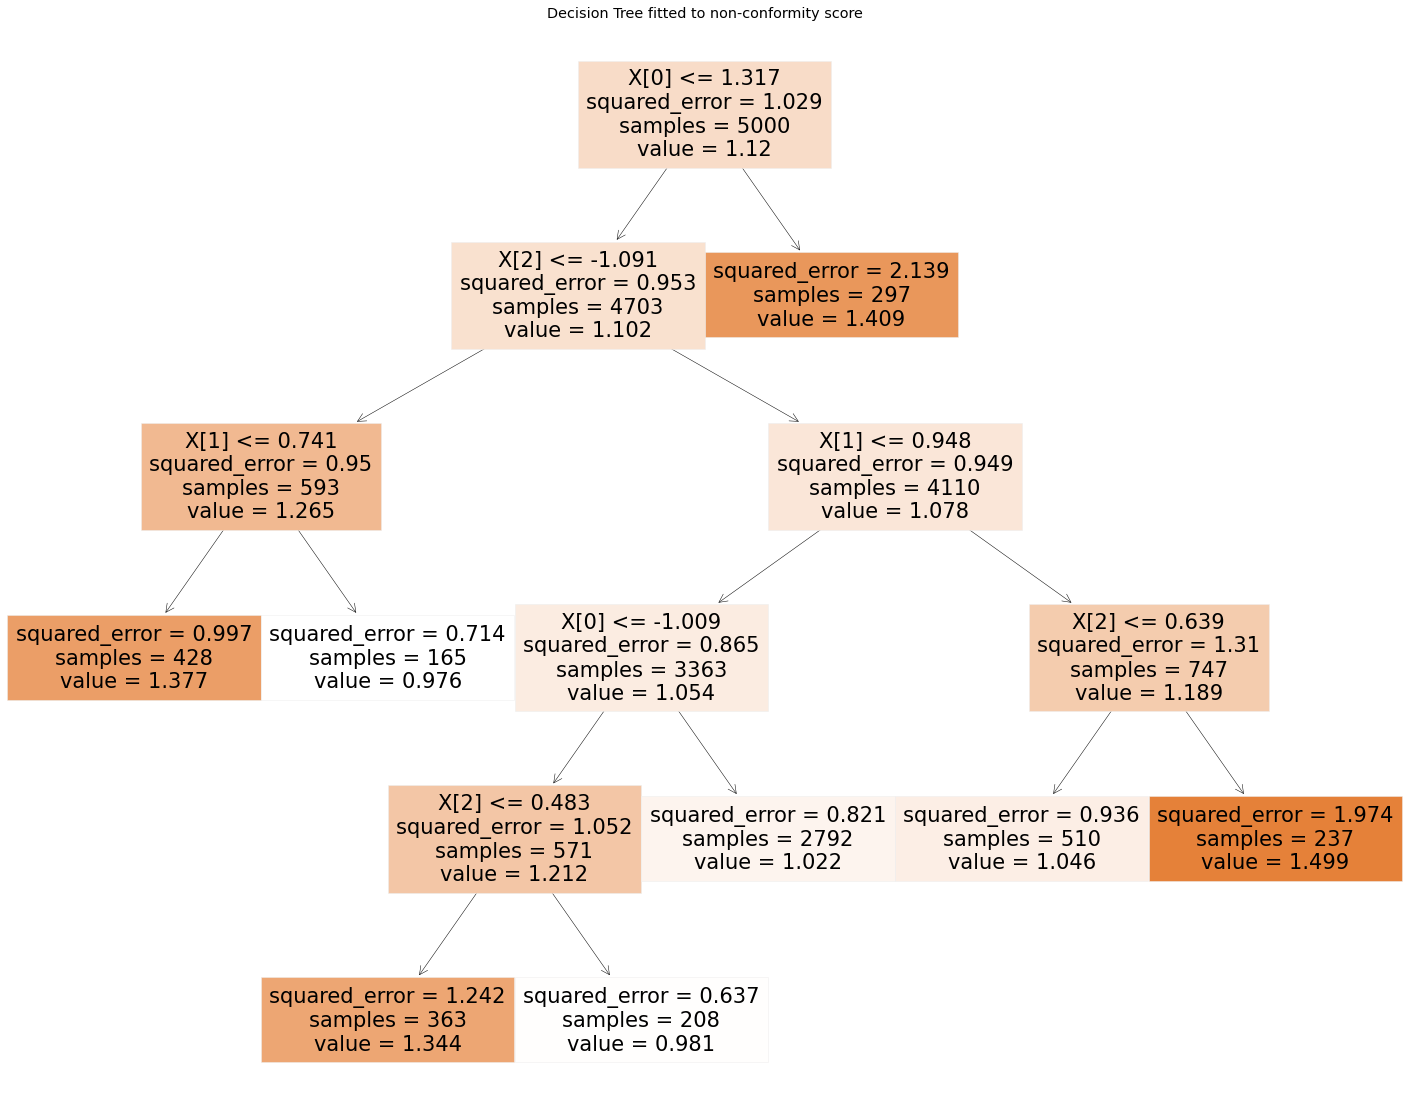

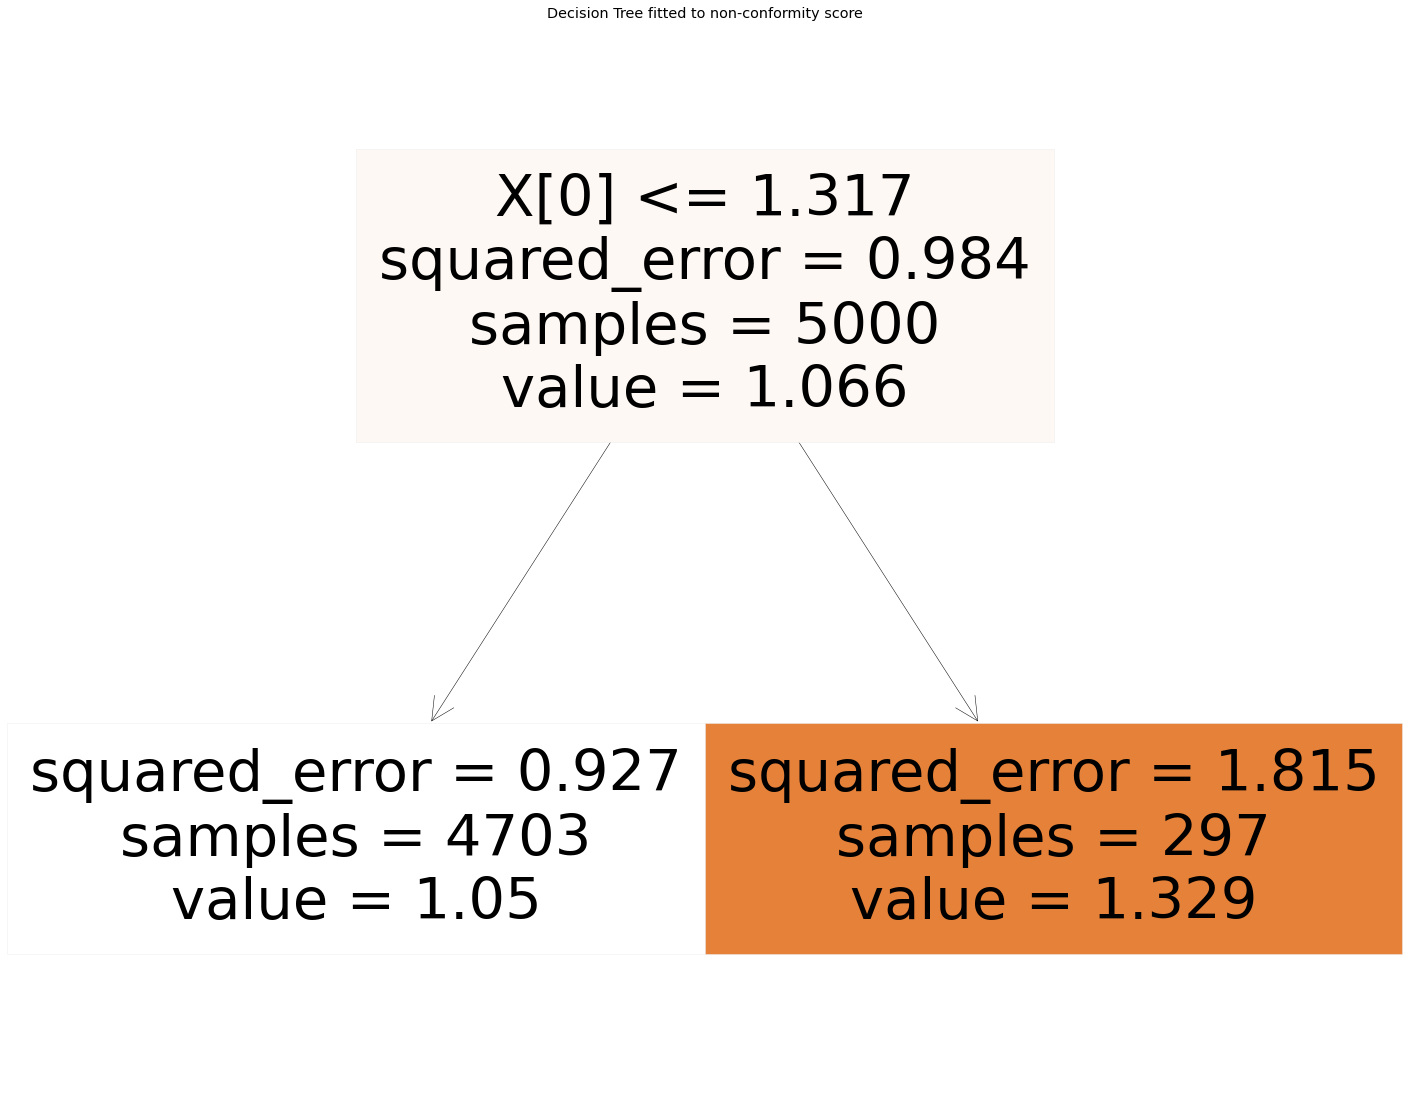

In [97]:
asym_metrics = testing_metrics_sim(base_model = KNeighborsRegressor, kind = "asymmetric", n_neighbors = 30, asym_value = 0.6, random_seed = 950, 
                                   valid_test_size=0.5, nbins = 30, noise = False, split_calib = True, valid_split = False, valid_prune = True, 
                                   valid_min_sample = 150, min_samples_leaf = 150)

In [98]:
asym_metrics

,Methods,valid pred set,smis,max pred set,Average marginal coverage,Average interval length,Average interval length given coverage,Average distance,Median distance,Max distance
0,LOCART,0.05756,-7.120521,0.219066,0.8920,4.310887,4.309177,0.053769,0.045,0.446
1,Weighted LOCART,0.05340,-7.257999,0.144966,0.8932,4.374298,4.399277,0.055278,0.046,0.505
2,Regresion split,0.06080,-7.244004,0.268421,0.8946,4.330983,4.330983,0.058208,0.049,0.431
3,Weighted regression split,0.05684,-7.287492,0.212500,0.8924,4.331743,4.353254,0.056174,0.046,0.502
4,Mondrian regression split,0.05472,-7.108407,0.192398,0.8926,4.353831,4.355966,0.055379,0.045,0.490


Fitting locart to toy example:
Time Elapsed to fit Locart:  3.9560415744781494
Computing metrics
Time Elapsed to compute metrics for Locart:  4.448857307434082
Fitting weighted locart to toy example:
Time Elapsed to fit Locart:  11.033176898956299
Computing metrics
Time Elapsed to compute metrics for Locart:  8.408629179000854
Fitting regression split
Time Elapsed to fit regression split:  3.5459554195404053
Computing metrics
Time Elapsed to compute statistics for regression split:  4.449241638183594
Fitting weighted regression split
Time Elapsed to fit weighted regression split:  10.548208236694336
Computing metrics
Time Elapsed to compute statistics for weighted regression split:  10.548208236694336
Fitting mondrian regression split
Time Elapsed to fit mondrian regression split:  49.62558650970459
Computing metrics
Cutoff points of wlocart: [1.92221087]
Cutoff point of wicp: 2.0057850824692247


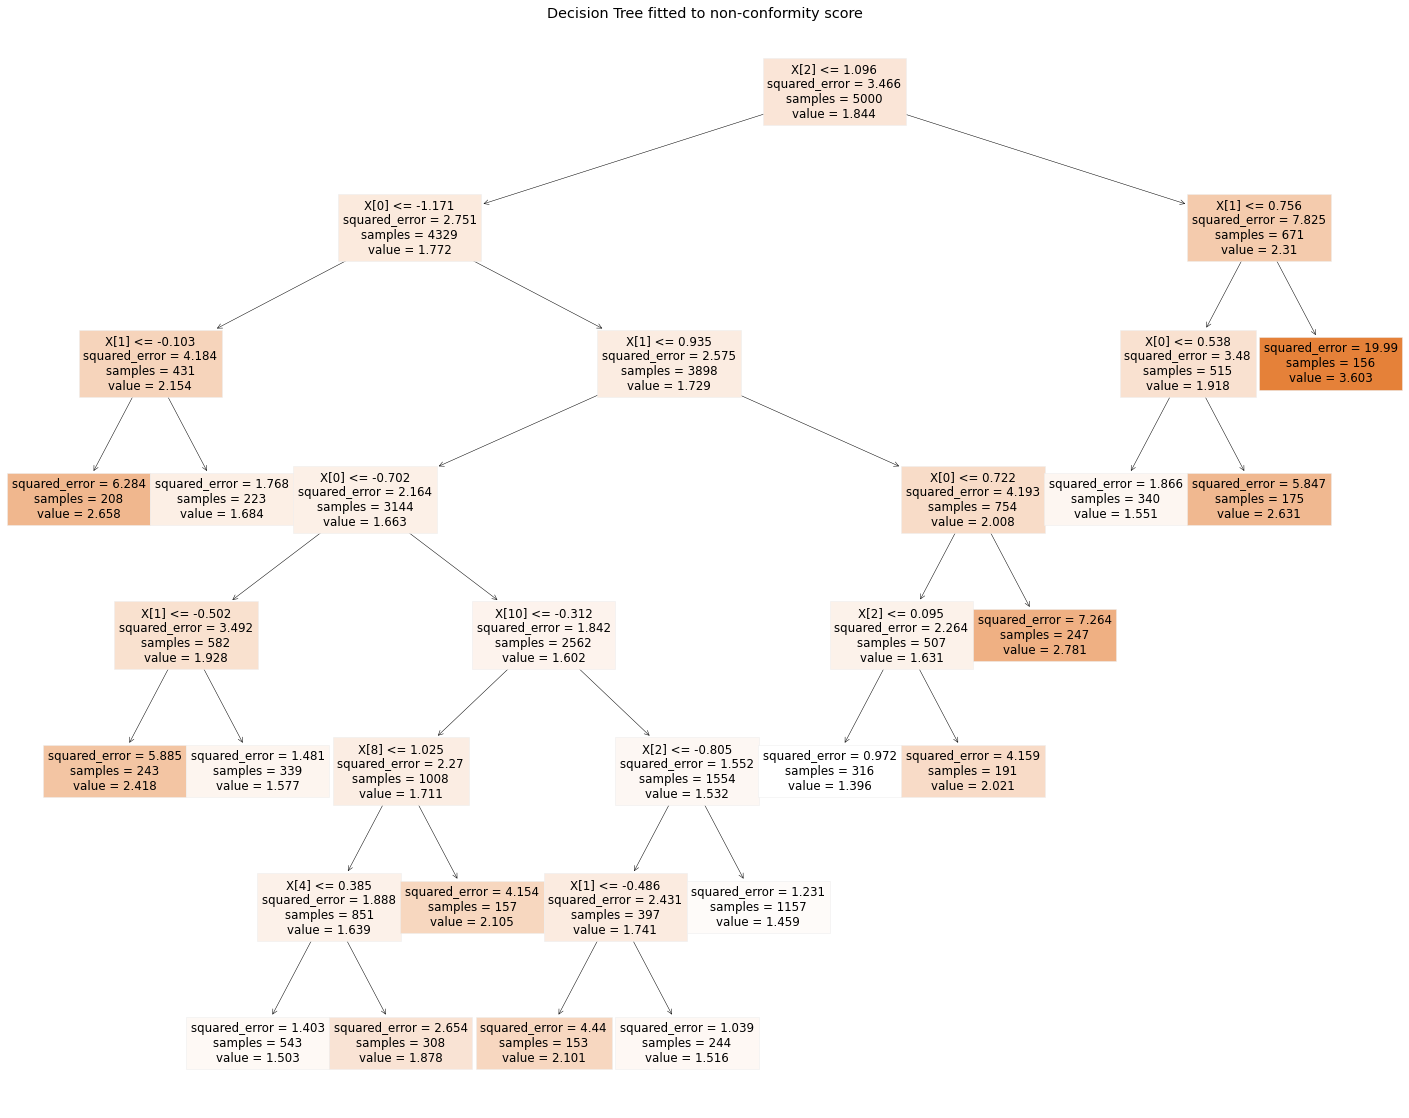

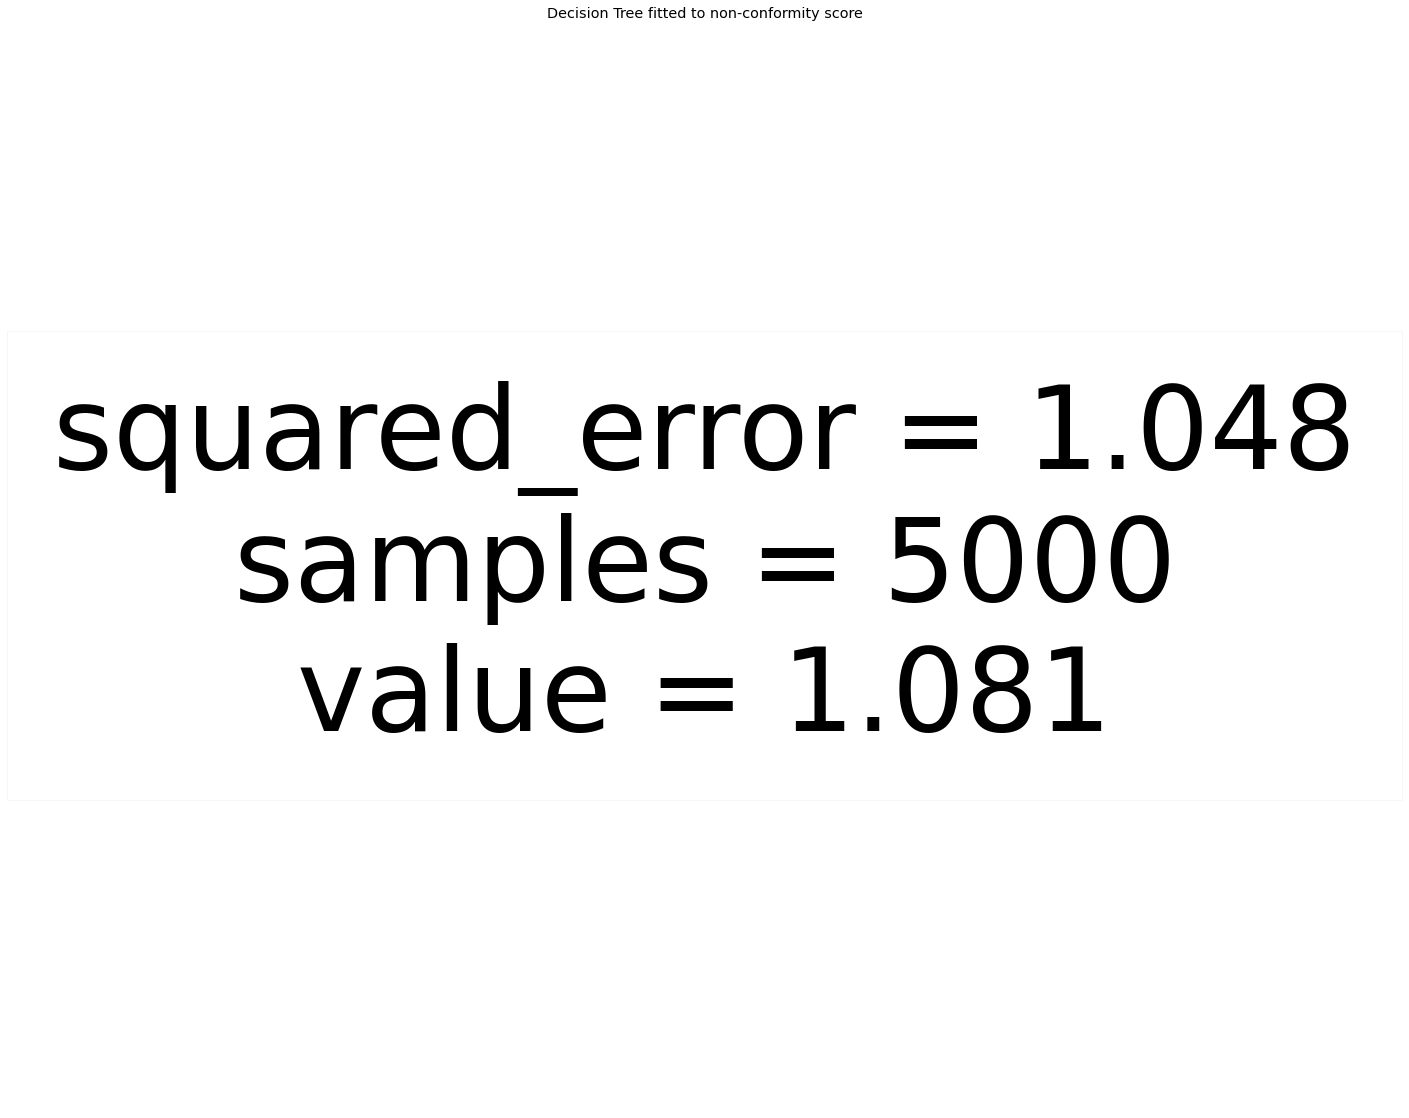

In [99]:
asym_v2_metrics = testing_metrics_sim(base_model = KNeighborsRegressor, kind = "asymmetric", n_neighbors = 30, asym_value = 1.5, random_seed = 950,
                                      valid_test_size=0.5, nbins = 30, noise = False, split_calib = True, valid_split = False, valid_prune = True, 
                                      valid_min_sample = 150, min_samples_leaf = 150)

In [100]:
asym_v2_metrics

,Methods,valid pred set,smis,max pred set,Average marginal coverage,Average interval length,Average interval length given coverage,Average distance,Median distance,Max distance
0,LOCART,0.05128,-11.331270,0.207692,0.8956,7.198080,7.229844,0.077302,0.068,0.658
1,Weighted LOCART,0.07572,-11.804936,0.259589,0.8920,6.568823,6.564253,0.081798,0.070,0.607
2,Regresion split,0.07864,-12.121243,0.425773,0.9030,7.033948,7.033948,0.086504,0.078,0.578
3,Weighted regression split,0.07352,-11.792740,0.251916,0.9002,6.854424,6.849438,0.079327,0.071,0.596
4,Mondrian regression split,0.05544,-10.833043,0.136287,0.8956,7.168416,7.176982,0.069254,0.058,0.578


Fitting locart to toy example:
Time Elapsed to fit Locart:  3.932994842529297
Computing metrics
Time Elapsed to compute metrics for Locart:  5.332683801651001
Fitting weighted locart to toy example:
Time Elapsed to fit Locart:  10.2777841091156
Computing metrics
Time Elapsed to compute metrics for Locart:  9.933421611785889
Fitting regression split
Time Elapsed to fit regression split:  3.2279319763183594
Computing metrics
Time Elapsed to compute statistics for regression split:  5.3696043491363525
Fitting weighted regression split
Time Elapsed to fit weighted regression split:  9.727927923202515
Computing metrics
Time Elapsed to compute statistics for weighted regression split:  9.727927923202515
Fitting mondrian regression split
Time Elapsed to fit mondrian regression split:  43.88989973068237
Computing metrics
Cutoff points of wlocart: [2.29940216]
Cutoff point of wicp: 2.2791154569877263


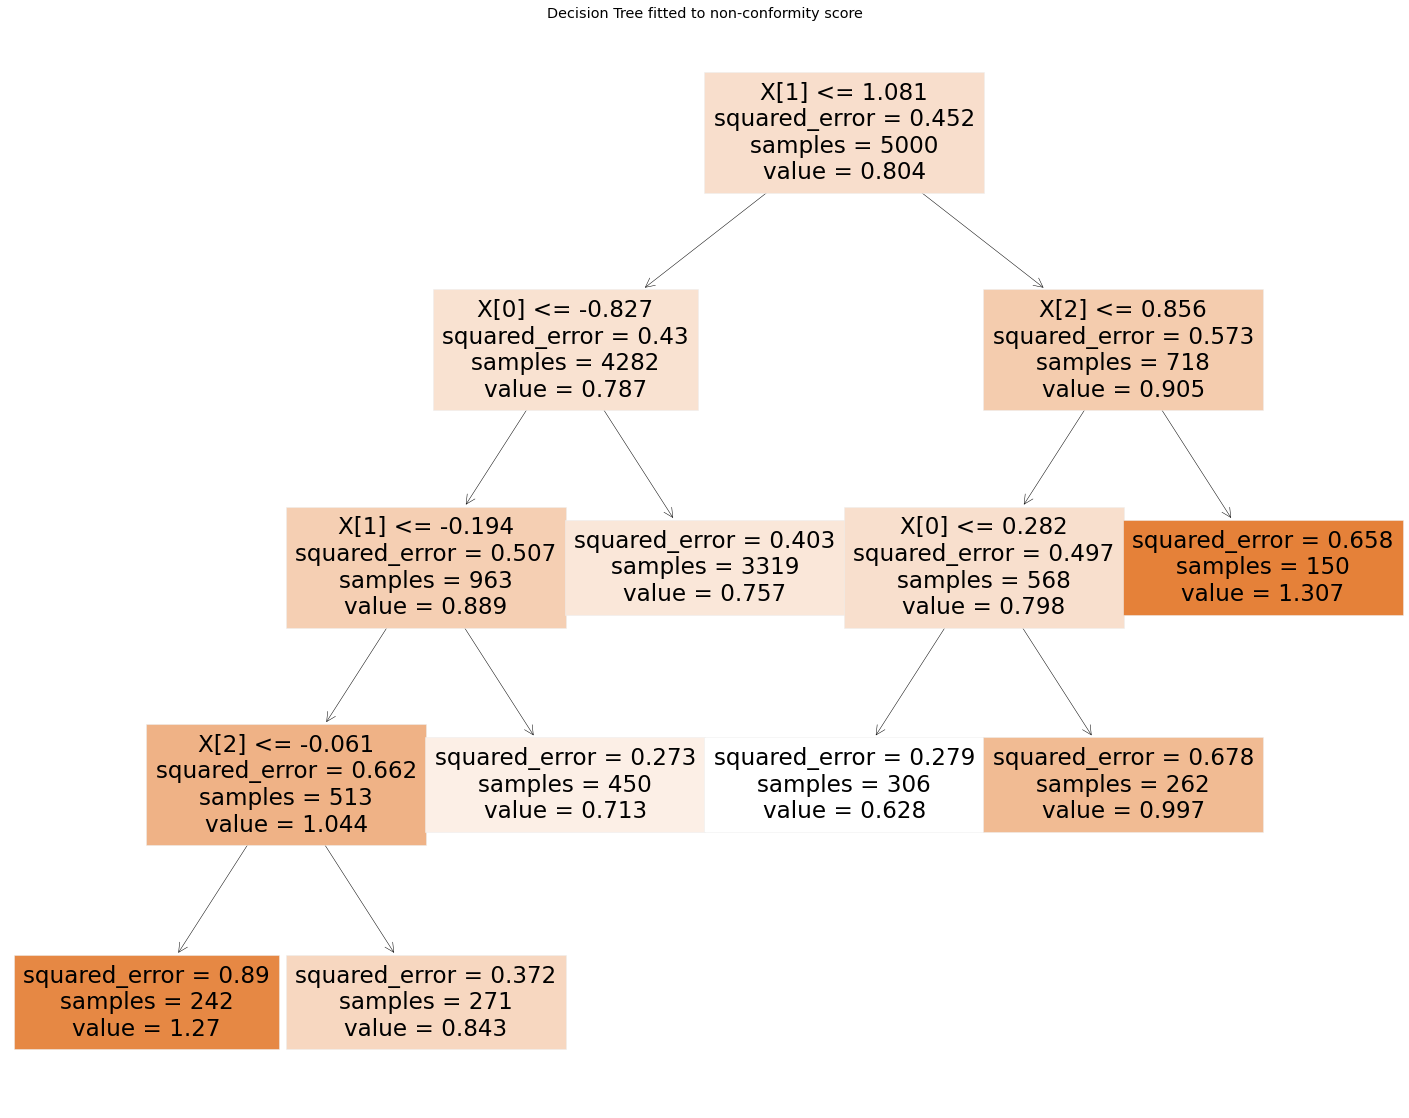

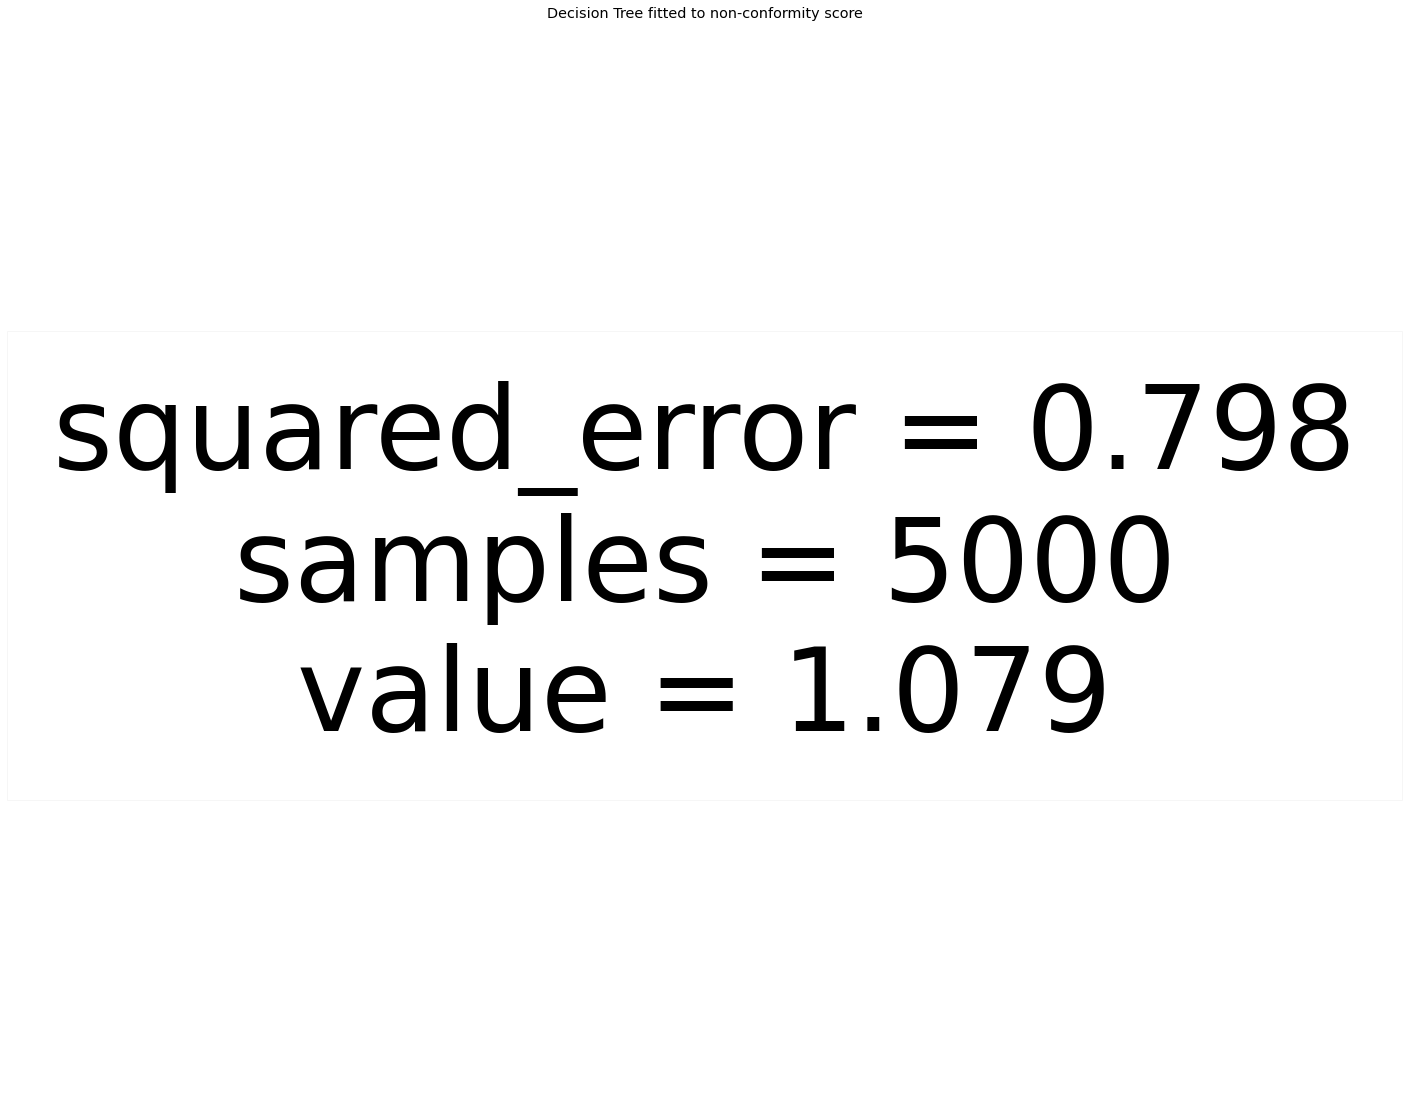

In [101]:
non_corr_heteroc_metrics = testing_metrics_sim(base_model = KNeighborsRegressor, kind = "non_cor_heteroscedastic", hetero_value = 0.25, n_neighbors = 30, random_seed = 950,
                                               valid_test_size=0.5, nbins = 30, noise = False,  split_calib = True, valid_split = False, valid_prune = True, 
                                               valid_min_sample = 150, min_samples_leaf = 150)

In [102]:
non_corr_heteroc_metrics

,Methods,valid pred set,smis,max pred set,Average marginal coverage,Average interval length,Average interval length given coverage,Average distance,Median distance,Max distance
0,LOCART,0.05040,-4.458085,0.153333,0.8960,3.377486,3.379838,0.062939,0.059,0.249
1,Weighted LOCART,0.05032,-4.473529,0.125166,0.9002,3.477926,3.490283,0.061227,0.058,0.307
2,Regresion split,0.05616,-4.518353,0.169231,0.8932,3.391125,3.391125,0.068880,0.067,0.254
3,Weighted regression split,0.04760,-4.472771,0.120126,0.8984,3.447241,3.459245,0.061877,0.057,0.312
4,Mondrian regression split,0.05220,-4.522613,0.151366,0.8902,3.315002,3.328665,0.068344,0.065,0.278
